In [1]:
# 1

########## 20 November 2018 - Alec S. Hirschauer ##########
# Today I am making a K vs J-K CMD for NGC 6822 using Python
# drawing from the Khan et al. (2015) Spitzer data set
# matched with the Sibbons et al. (2012) WFCAM/UKIRT data set.
#
# I will be implementing histograms binned by K-magnitude
# in effort to isolate where in J-K color space we should be
# placing boundaries for segregating oxygen-rich AGB stars
# from carbon-rich AGB stars.
#
# Typical values for these vertical lines are at (about):
# J-K = 0.7 (separating foreground stars from M-type/O-rich AGBS)
# J-K = 1.2 (separating M-type/O-rich AGBs from C-type/C-rich AGBs)
#
# While vertical separation lines are useful, Libby Jones is
# in favor of diagonal boundaries, which better follow the shape
# of the structure of AGB star points on the CMDs themselves.
#
# One way to investigate this is a technique Martha Boyer suggested
# from a paper by Rosenfield et al. (2016), which basically takes
# histograms as described above, but in small increments of y-axis
# (say, 0.1 magnitudes wide) to determine what the slope would be.
#
# This Python notebook will only deal with the K vs J-K CMD, but
# future notebooks will investigate other relevant CMDs and colors
# which will also be useful in identifying AGB star candidates.
#________________
#
# As of 12 November 2018, Owen Boberg has helped me with estimating
# the histogram inflection points using Gaussian KDEs.
#________________
#
# As of 20 November 2018, I will optimize both horizontal (J-K) and
# vertical (K-band) binwidths, rather than selecting arbitrary ones,
# in effort to account for statistical Poisson uncertainties in the
# photometry that I am using.
#
# In particular, the vertical bin width has to be appreciably better
# than the photometric uncertainties (maybe 5-sigma?).
#
# Also, I will identify not just the C-rich/M-type AGB star candidates
# and the O-rich/O-type AGB star candidates, but also the extremely
# dusty sources way redward on the plot *and* a small branch at about
# J-K = 1.0 that Libby saw which could represent the first dusty track
# of O-rich AGB stars.
#
# NB: I still need the horizontal TRGB boundary from Libby, which for now
# is set as K=17.1, from the Sibbons+ study (which uses K_s, not K).
#
# In principle, I should determine where the vertical bins start based
# off of this number.

In [2]:
# 2

# First thing needed is to import the relevant Python libraries.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.stats import gaussian_kde
# This line is necessary for the number density histograms.
from astropy import stats
from astropy.stats.histogram import knuth_bin_width
# This line is necessary for determining histogram bin width.

In [3]:
# 3

# Read in my data from a .csv file saved locally.
phot_data = pd.read_csv('CMDKhanANDSibbonsHOME_ahirschauer.csv')
# This is a table of values with 30,745 rows which contains the photometric data of
# the Khan et al. (2015) catalog matched to sources from Sibbons et al. (2012)
# with an "OR" command, then downloaded from MAST CasJobs.
# print phot_data
#
# Also I'll read in the entire Sibbons+ stellar source catalog.
Sibbons_data = pd.read_csv('Sibbons2012NGC6822.csv')
# This is for a test of the histogram(s) I make later on.

In [4]:
# 4

# For the histograms, I have created new .csv files which have the specific colors'
# information: ID, RA, Dec, magnitudes, magnitude errors, color, color error.
#
# I have pre-trimmed the bogus data from these tables already, so there's no need
# to get rid of the whacky 'null' values converted to "-9999" values
# (which, when subtracted from any other value, gives another bogus value)
# like I did in the previous cell with the "full" catalog.
#
jMINUSkDATA = pd.read_csv('jMINUSk.csv')
jMINUSthreesixDATA = pd.read_csv('jMINUSthreesix.csv')
threesixMINUSeightzeroDATA = pd.read_csv('threesixMINUSeightzero.csv')
jMINUSeightzeroDATA = pd.read_csv('jMINUSeightzero.csv')
#
# After comparing cells where I made CMDs with the "filter_phot_data" data and with
# the specific colors' information above, I have found that they are the same!
# I will use these data instead of calling from the larger catalog.
#
# These two were made following a meeting with Margaret on 2 October 2018.
eightzeroMINUStwentyfourDATA = pd.read_csv('eightzeroMINUStwentyfour.csv')
fourfiveMINUSeightzeroDATA = pd.read_csv('fourfiveMINUSeightzero.csv')
#
# NB: the bin width routine Libby sent me had previously produced values that were
# clearly too big, which is probably due to "NULL" or "-9999" values in the inputs.
#________________
#
# update (27 Nov 2018): uploaded a jMINUSk .csv file
# that has been trimmed of all sources with magnitude
# errors greater than 0.1, as a test for optimum
# histogram bin width calculations later.
jMINUSkDATA_test = pd.read_csv('jMINUSk_test.csv')

In [5]:
# 5

# The first thing I'll do here is make the J vs J-K CMD & Hess diagram.

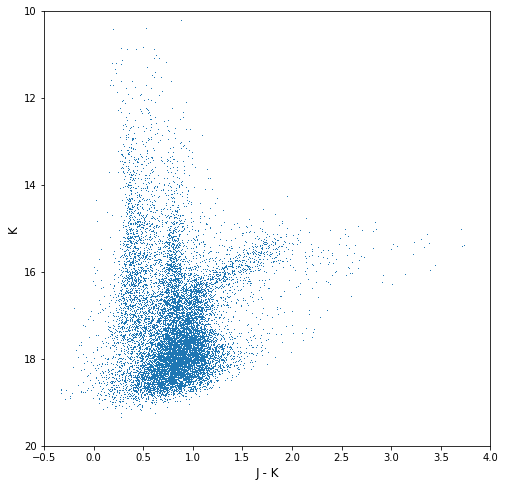

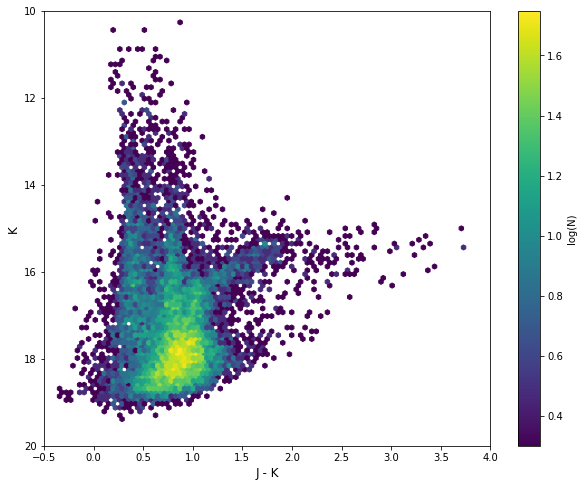

In [6]:
# 6

# K vs J-K
# CMD & Hess diagram
#
plt.figure(figsize=(8,8))
plt.plot(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#plt.savefig('K_vs_J-K_plot.pdf')
#
fig, ax1 = plt.subplots(1, 1, figsize=(10, 8))
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
im1 = ax1.hexbin(jMINUSkDATA.jMINUSk, jMINUSkDATA.Kmag, bins='log', cmap=plt.cm.viridis,
               mincnt=1, extent=(-0.5, 4.0, 20.0, 10.0))
ax1.set_xlabel('J - K', size=12)
ax1.set_ylabel('K', size=12)
cb = plt.colorbar(im1, label='log(N)')
#plt.savefig('K_vs_J-K_hist.pdf')

In [7]:
# 7

# The second thing I'll do is make the first histogram, which uses all the data
# (no restriction in K-band), so it's basically one big lump.
#________________
#
# I am going to try using Libby Jones' optimum bin width routine here rather than
# manually setting semi-arbitrary bin widths as I had done before, but with an
# expectation that the values should be more or less the same.

0.12653999999999999
0.13349999999999973


/Users/ahirschauer/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


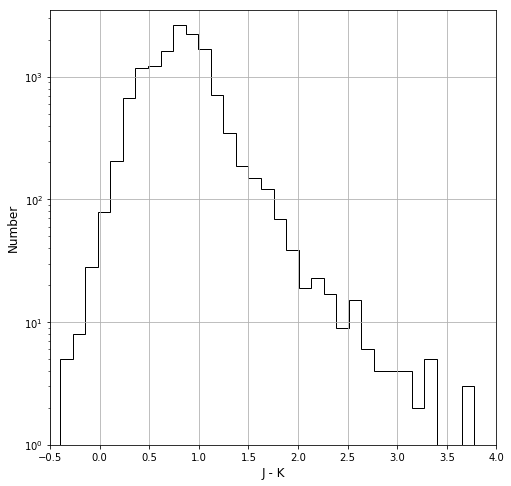

In [8]:
# 8

# J-K
# histogram
#
# these are the horizontal (J-K) bins
#binwidth = 0.1
binwidth = (stats.knuth_bin_width(jMINUSkDATA.jMINUSk))
bin_number = (max(jMINUSkDATA.jMINUSk)+binwidth)/binwidth
#
print binwidth
#print bin_number
#
# these are the vertical (K-band) bins
#binwidth2 = 0.25
binwidth2 = (stats.knuth_bin_width(jMINUSkDATA.Kmag))
bin_number2 = (max(jMINUSkDATA.Kmag)+binwidth2)/binwidth2
#
print binwidth2
#print bin_number2
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkDATA.jMINUSk, bins=np.arange(min(jMINUSkDATA.jMINUSk), max(jMINUSkDATA.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
plt.ylim(0.0, 3500.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#________________
#
# update (27 Nov 2018): These bin widths are for all sources in the catalog.

In [9]:
# 9

# I have implemented Libby's optimum bin width code here to calculate the
# optimum bin width (duh) in both the horizontal (J-K) direction and vertical
# (K-band) direction.
#
# By specifying the correct input file, I got it to work!  Fancy that.
#
# With optimum bin withs rather than semi-arbitrarily selected ones, I can
# go ahead and re-do the inflection point local minima analysis from before.
#
# But first I should test to see if these optimum bin width values are variable
# depending on over where in the CMD you are sampling the data.  My guess is "yes".
#________________
#
# The third thing I'll do is make a different histogram with a restricted
# K-band range, to illustrate how isolating some data can help bring out
# the details of the CMD.
#
# For a start, I'll only plot K-values between 14.0 and 16.0.

0.10433043478260869
0.11741176470588321


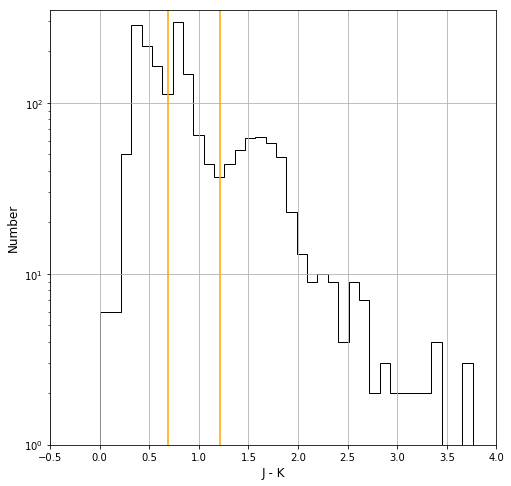

In [10]:
# 10

# J-K
# histogram (where phot_data.Kmag = 14.0 to 16.0)
#
jMINUSkHIST0 = jMINUSkDATA[(jMINUSkDATA.Kmag < 16.0) & (jMINUSkDATA.Kmag > 14.0)]
#
#print jMINUSkHIST0.Jmag
#print jMINUSkHIST0.Kmag
#print jMINUSkHIST0.jMINUSk
#print jMINUSkHIST0.eJmag
#print jMINUSkHIST0.eKmag
#print jMINUSkHIST0.ERRORjMINUSk
#
# these are the horizontal (J-K) bins
#binwidth = 0.1
binwidth = (stats.knuth_bin_width(jMINUSkHIST0.jMINUSk))
bin_number = (max(jMINUSkHIST0.jMINUSk)+binwidth)/binwidth
#
print binwidth
#print bin_number
#
# these are the vertical (K-band) bins
#binwidth2 = 0.25
binwidth2 = (stats.knuth_bin_width(jMINUSkHIST0.Kmag))
bin_number2 = (max(jMINUSkHIST0.Kmag)+binwidth2)/binwidth2
#
print binwidth2
#print bin_number2
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST0.jMINUSk, bins=np.arange(min(jMINUSkHIST0.jMINUSk), max(jMINUSkHIST0.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlim(-0.5, 4.0)
plt.ylim(0.0, 350.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.axvline(x=0.69, linewidth=1.5, color='orange') # left inflection point *estimate*
plt.axvline(x=1.21, linewidth=1.5, color='orange') # right inflection point *estimate*
plt.grid(True)
plt.show()
plt.close()
#________________
#
# update (27 Nov 2018): These bin widths are only for sources between K = 14.0 to 16.0.

In [11]:
# 11

# As you can see, the inflection points are at roughly
# J-K = 0.7 and J-K = 1.2.
#________________
#
# update (7 Nov 2018): set above as J-K = 0.69 and J-K = 1.21.
# I still haven't implemented Libby's binwidth command, though.
# (e-mailed Libby 9 Nov 2018)
#________________
#
# update (20 Nov 2018): I got the optimum bin width stuff figured
# out, and the orange lines seem to work really well!
#
# Also note that the optimum vertical bin width calculation for
# *all* points = 0.133, while for K = 14.0 to 16.0, it's = 0.117.
#
# These are smaller than my earlier 0.25 dex wide bins, which I
# already thought might be too small.
#________________
#
# I'd like to implement some analysis tool that will figure out
# what that value is to more precision, but also, I'll next make
# progressive histograms which use a more restricted K-band range
# to see where these inflection points will be up the CMD.
#
# ^ Owen Boberg is going to help me out with that.
# update (12 Nov 2018): he did!

In [12]:
# 12

# Rather than estimate where the inflection points are over any
# given range of CMD y-values (in this case, K-band), I'm going to
# fit the histogram with a curve, then determine where the inflection
# points are, indicating the position of local minima.
#
# The following are a series of commands that Owen Boberg showed me
# to create the histogram fit curve.
#
# My intention is to recreate this curve for every y-value range bin
# to determine where the color-cut x-value is, then fit a line to these
# values in order to make a slanted color-cut for AGB star identification.
#_______________
#
# update (20 Nov 2018): Libby Jones recommends that, for determining the
# color cuts, I only use sources with low photometric errors (< 0.1 mag).
# ***But does this mean J-, K-, or J-K?***
#________________
#
# update (26 Nov 2018): Libby's response is essentially that if either of
# the two bands' magnitudes have errors that are less than 0.1, then that
# color shouldn't be included in the analysis.

/Users/ahirschauer/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


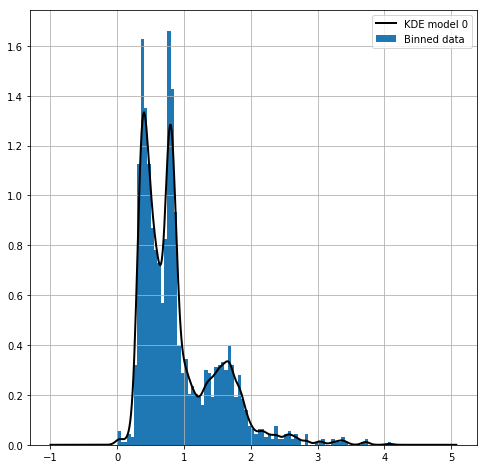

In [13]:
# 13

# Here's the conglomerated series of commands that Owen used to make a
# curve to fit the histogram(s).

kde_data0 = jMINUSkHIST0.jMINUSk[(jMINUSkHIST0.jMINUSk > -100.0) & (jMINUSkHIST0.jMINUSk < 5.0)].values
#kde_data0 = jMINUSkHIST0.jMINUSk[(jMINUSkHIST0.ERRORjMINUSk < 0.1)].values

#print kde_data0

# ^ This defines the range of data to be used for the Kernel Density Estimation (KDE).
# "kde_data" will be appended with "_#" for successive y-value bin ranges.
#
# NB: I think these cuts are superfluous, since the input files are already culled of 'null' values,
# but I remember Owen saying something about how it's important for the Gaussian fitting?
# For now the cut is greater than -100.0 and less than 5.0 (formerly 3.0).
#
# Since I want to identify the extremely dusty things out past J-K = 3.0, I need to keep
# those data so that I can define minima out 

bins=np.arange(min(kde_data0 ), max(kde_data0 ) + 0.05, 0.05)

# ^ This defines the bins over which the KDE will be plotted.

#kde = gaussian_kde(kde_data,bw_method=0.05)
#or kde = gaussian_kde(kde_data)

# ^ This defines the KDE as a Gaussian to be evaluated over the range of data defined earlier,
# with either binwidths of 0.05 (top) or calculated by the routine and not set manually.

#plt.hist(kde_data,normed=True,bins=bins)

# ^ This plots the KDE estimate for the histogram (linear, not log, which is important).
# In the first plot output, this is the blue histogram; the black line comes later.

x_eval = np.linspace(kde_data0.min() - 1.0, kde_data0.max() + 1.0, 500)

# ^ This evaluates the x-values of the histogram(?), with the KDE minimum and KDE maximum
# as arguments, though I don't fully understand the trailing "500" (or the +/- 1.0s).

#plt.plot(x_eval, kde(x_eval), 'k-')
#plt.xlim(0.60, 0.75)
#plt.ylim(0.5, 0.7)
#plt.grid(True)

# ^ This plots the black line over the blue histogram in the first output plot.

#from scipy.optimize import curve_fit
#from scipy.optimize import leastsq

# ^ These call some fitting algorithms that we didn't end up using, so this could be skipped.

kde_0 = gaussian_kde(kde_data0,bw_method=0.1)
# kde_0 = gaussian_kde(kde_data_0)

# ^ This defines a KDE as a Gaussian to be evaluated over the range of data defined earlier,
# with binwidths of 0.1, very similarly to the third command from the top.

#kde_0.scotts_factor()

# ^ This prints out the value of the KDE, which I think is effectively the binwidth.

plt.figure(figsize=(8,8))
plt.plot(x_eval, kde_0(x_eval),'k',lw=2,label='KDE model 0')
plt.hist(kde_data0,bins=bins,normed=True,label='Binned data')
#plt.xlim(0.6, 0.75)
#plt.ylim(0.5, 0.8)
#plt.xlim(1.15, 1.3)
#plt.ylim(0.16, 0.22)
plt.legend()
plt.grid(True)
plt.show()
plt.close()

# ^ This plots the fit to the second histogram, giving a looser value of the inflection
# points and therefore the local minima as compared to the first histogram, but by not
# following so many of the nooks and crannies, it might do a better job of characterizing
# where to set the color cuts, especially since this doesn't *need* to be too rigorous.
#
# I commented out everything for the first histogram, so I can just use what's left for
# the "mass production" of fit curves for each swathe.
#
# The next step would be to calculate the local minima somehow OR simply zoom in to where
# the minima are and estimate the J-K value to some precision (hundreth's place?).
#
### with binwidth = 0.10, J-K = 0.65, J-K = 1.22
### with binwidth = 0.05, J-K = 0.68, J-K = 1.26* (double minimum)

In [14]:
#14

# The above is a histogram plus KDE fit to the K = 14.0 to 16.0 data
# when the J-K color is restricted to between -1.0 and 5.0,
# with manually set horizontal bins 0.10 dex wide.
#
# While this *does* cut off some data, that's not a problem,
# since the cut is only to help with the KDE fit to the data.
# 
# What needs to happen now (27 Nov 2018) is the following:
#
# [1] Create new data from jMINUSkDATA which only includes sources
#     that have both J-band *and* K-band errors less than 0.1.
#
# [2] Use these low-error color values to determine the optimum 
#     horizontal bin width for each vertical bin, starting at K = 17.1.
#
# [3] Determine the optimum vertical bin width over the appropriate range
#     of K-band photometric values.
#     This could be *all* points, only those in a reasonable range to be
#     measured (like from K = 17.1 to whenever the points get too scarce),
#     and potentially variable depending on how many points are in the boxes.
#
#     For comparison, I had had 0.25 dex wide bins before, which was mostly
#     okay, but definitely suffered from small-number statistics at the edges.
#
# Let's try to make [1]:

low_error_jMINUSkDATA = jMINUSkDATA[(jMINUSkDATA.eJmag < 0.1) & (jMINUSkDATA.eKmag < 0.1)]

print len(jMINUSkDATA)
print len(low_error_jMINUSkDATA)
print len(jMINUSkDATA_test)

# Okay, apparently that didn't work, since I got an empty set back.
# update (27 Nov 2018):  I got it to work!  NB keep track of parantheses.

13351
8504
8504


In [15]:
# 15

# Now that step [1] is done, I really have to decide on step [3] before I can
# do the work for step [2], since the ranges of the various vertical bins (J-K)
# depends on where they start in K-band magnitude space.
#
# If I set the TRGB threshold at K = K_s = 17.1 a la Sibbons+ (2012), ignoring
# the small differences between the K and K_s filters, then the starting point
# is easy enough.
#
# BTW, according to https://www.ipac.caltech.edu/2mass/releases/allsky/doc/sec6_4b.html,
# 2MASS - UKIRT
# (Ks)2MASS = KUKIRT + (0.003 ± 0.004) + (0.004 ± 0.006)(J – K)UKIRT
# so the difference between K and K_s is generally small, with Sibbons+ (2012)
# implying that the difference is K being fainter than K_s by roughly 0.08 mags.
#
# Earlier on, I had computed the vertical bin widths using all the data:

# these are the vertical (K-band) bins
#binwidth2 = 0.25
binwidth2 = (stats.knuth_bin_width(jMINUSkDATA.Kmag))
bin_number2 = (max(jMINUSkDATA.Kmag)+binwidth2)/binwidth2
#
print binwidth2
#print bin_number2

# To find the vertical (K-band) bins for only the low-error K-mag data,
# I can isolate only the data with K-mag errors less than 0.1:
#
low_Kerror_jMINUSkDATA = jMINUSkDATA[(jMINUSkDATA.eKmag < 0.1)]
#
binwidth3 = (stats.knuth_bin_width(low_Kerror_jMINUSkDATA.Kmag))
bin_number3 = (max(low_Kerror_jMINUSkDATA.Kmag)+binwidth3)/binwidth3
#
print binwidth3
#print bin_number3

# Or I can calculate this using sources with both K-band and J-band errors
# that are less than 0.1, as defined by step [1] earlier:
#
binwidth4 = (stats.knuth_bin_width(low_error_jMINUSkDATA.Kmag))
bin_number4 = (max(low_error_jMINUSkDATA.Kmag)+binwidth4)/binwidth4
#
print binwidth4
#print bin_number4

#________________________________________________________________________________
# This is a test to see if the data filtering used by Python
# will produce a table that will give the same results as a table
# that was produced by manually removing all the photometric points
# with errors greater than 0.1, since this Knuth method routine
# has been giving me fits all day.
#
binwidthtest = (stats.knuth_bin_width(jMINUSkDATA_test.Kmag))
bin_numbertest = (max(jMINUSkDATA_test.Kmag)+binwidthtest)/binwidthtest
#
print binwidthtest
# print bin_numbertest
#
# ^ These numbers are the same!
# Apparently the filtering didn't introduce a whole bunch of 'null'
# values like I expected it to.
# Back to the drawing board, I suppose...
#________________________________________________________________________________

# The values for the bin widths are, respectively, 0.133, 0.176, and 0.144.
# Since my earlier, manually-entered bin widths were 0.25 dex wide, and all
# of these bin width values are noticeably smaller than that, I have to decide
# what I want to do.
#
# Considering that for some bins I had been running into small-number statistics
# errors, it may be necessary to double the bin widths in these places.

#________________________________________________________________________________
# I also want to test whether the results are the same for determining
# optimum histogram bin width between the Python-filtered catalog and the
# manually-filtered catalog for horizontal bins.
#
bintest1 = (stats.knuth_bin_width(low_error_jMINUSkDATA.jMINUSk))
bintest2 = (stats.knuth_bin_width(jMINUSkDATA_test.jMINUSk))
#
print bintest1
print bintest2
#
# Yep!  They're the same here, too.
#
# Side note: The optimum horizontal bin width for all sources with
# photometric errors less than 0.1 is = 0.037854368932038834...
# Maybe I can try using that, instead of a per-bin basis?
#________________________________________________________________________________

0.13349999999999973
0.17617647058823493
0.14448387096774162
0.14448387096774162
0.037854368932038834
0.037854368932038834


In [16]:
# 16

# Maybe I should try restricting the y-direction sources to figure out
# the optimum vertical bin widths?
#
# How about the low-error K-mag data above the TRGB limit at K_s = 17.1,
# plus a boundary at the faint end (previously arbitrarily set at 13.0)
# and bound the J-K values as before?
#
testarray_jMINUSkDATA = low_Kerror_jMINUSkDATA[(low_Kerror_jMINUSkDATA.Kmag < 17.1)
                                              & (low_Kerror_jMINUSkDATA.Kmag > 12.0)
                                              & (low_Kerror_jMINUSkDATA.jMINUSk > -100.0)
                                              & (low_Kerror_jMINUSkDATA.jMINUSk < 5.0)]

#print testarray_jMINUSkDATA
#
binwidth5 = (stats.knuth_bin_width(testarray_jMINUSkDATA.Kmag))
bin_number5 = (max(testarray_jMINUSkDATA.Kmag)+binwidth5)/binwidth5
#
print binwidth5
#print bin_number5
#

# Oddly enough, by setting the faint-end y-axis boundary at 13.0 (and 11.0), the
# optimum bin width calculation jumps up to about 0.454, while everywhere else
# the value remains hovering around 0.137.
#
# So somehow there's a reason why "13.0" and "11.0" as boundaries make the
# optimum bin width increase by a factor of about three as compared to all
# other values of the boundary.
#
# My guess is it has something to do with the specifics of the routine itself,
# though I can't figure out what it is specifically.
#
# So I don't waste any additional time on this problem, I'll set a representative
# value of the faint-end boundary at 12.0 and use the optimum bin width from that,
# which is almost exactly = 0.137.

# Double-wide bin widths will be = 0.274, triple-wide = 0.411, quadruple-wide = 0.548.
#
# I don't have a strict criteria for how many sources have to fall into a bin
# in order to be enough, but I feel like the histogram maximums will show that.

# So now that steps [1] and [3] are set, I will define the vertical bins of the
# histograms starting from K_s = 17.1, going up (or really down, since magnitudes
# are stupid and are backwards) in increments of 0.137.
#
# Bin  1: K_s = 17.100 to 16.963, center @ 17.0315
# Bin  2: K_s = 16.963 to 16.826, center @ 16.8945
# Bin  3: K_s = 16.826 to 16.689, center @ 16.7575
# Bin  4: K_s = 16.689 to 16.552, center @ 16.6205
# Bin  5: K_s = 16.552 to 16.415, center @ 16.4835
# Bin  6: K_s = 16.415 to 16.278, center @ 16.3465
# Bin  7: K_s = 16.278 to 16.141, center @ 16.2095
# Bin  8: K_s = 16.141 to 16.004, center @ 16.0725
# Bin  9: K_s = 16.004 to 15.867, center @ 15.9355
# Bin 10: K_s = 15.867 to 15.730, center @ 15.7985
# Bin 11: K_s = 15.730 to 15.593, center @ 15.6615
# Bin 12: K_s = 15.593 to 15.456, center @ 15.5245
# Bin 13: K_s = 15.456 to 15.319, center @ 15.3875
# Bin 14: K_s = 15.319 to 15.182, center @ 15.2505
# Bin 15: K_s = 15.182 to 15.045, center @ 15.1135
# Bin 16: K_s = 15.045 to 14.908, center @ 14.9765
# Bin 17: K_s = 14.908 to 14.771, center @ 14.8395
# Bin 18: K_s = 14.771 to 14.634, center @ 14.7025
# Bin 19: K_s = 14.634 to 14.497, center @ 14.5655
# Bin 20: K_s = 14.497 to 14.360, center @ 14.4285
# Bin 21: K_s = 14.360 to 14.223, center @ 14.2915
# Bin 22: K_s = 14.223 to 14.086, center @ 14.1545
# Bin 23: K_s = 14.086 to 13.949, center @ 14.0175
# Bin 24: K_s = 13.949 to 13.812, center @ 13.8805
# Bin 25: K_s = 13.812 to 13.675, center @ 13.7435
# Bin 26: K_s = 13.675 to 13.538, center @ 13.6065
# Bin 27: K_s = 13.538 to 13.401, center @ 13.4695
# Bin 28: K_s = 13.401 to 13.264, center @ 13.3325
# Bin 29: K_s = 13.264 to 13.127, center @ 13.1955
# Bin 30: K_s = 13.127 to 12.990, center @ 13.0585

0.13700000000000045


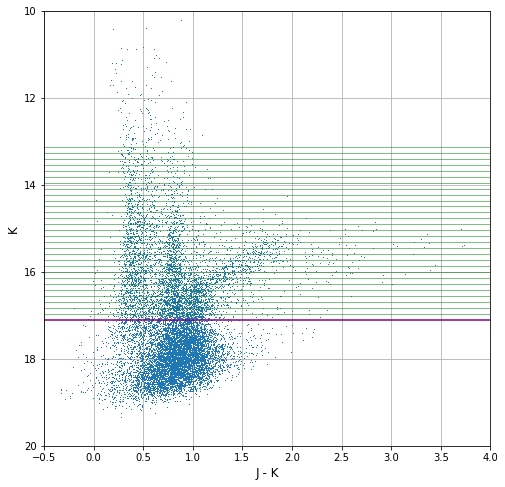

In [17]:
# 17

# To complete step [2], let's see what the K vs J-K CMD looks like
# with the boundary lines established above.

# K vs J-K
# CMD with boundary lines
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=17.100, linewidth=1.5, color='purple') # TRGB threshold
plt.axhline(y=16.963, linewidth=0.5, color='green') # Bin  1
plt.axhline(y=16.826, linewidth=0.5, color='green') # Bin  2
plt.axhline(y=16.689, linewidth=0.5, color='green') # Bin  3
plt.axhline(y=16.552, linewidth=0.5, color='green') # Bin  4
plt.axhline(y=16.415, linewidth=0.5, color='green') # Bin  5
plt.axhline(y=16.278, linewidth=0.5, color='green') # Bin  6
plt.axhline(y=16.141, linewidth=0.5, color='green') # Bin  7
plt.axhline(y=16.004, linewidth=0.5, color='green') # Bin  8
plt.axhline(y=15.867, linewidth=0.5, color='green') # Bin  9
plt.axhline(y=15.730, linewidth=0.5, color='green') # Bin 10
plt.axhline(y=15.593, linewidth=0.5, color='green') # Bin 11
plt.axhline(y=15.456, linewidth=0.5, color='green') # Bin 12
plt.axhline(y=15.319, linewidth=0.5, color='green') # Bin 13
plt.axhline(y=15.182, linewidth=0.5, color='green') # Bin 14
plt.axhline(y=15.045, linewidth=0.5, color='green') # Bin 15
plt.axhline(y=14.908, linewidth=0.5, color='green') # Bin 16
plt.axhline(y=14.771, linewidth=0.5, color='green') # Bin 17
plt.axhline(y=14.634, linewidth=0.5, color='green') # Bin 18
plt.axhline(y=14.497, linewidth=0.5, color='green') # Bin 19
plt.axhline(y=14.360, linewidth=0.5, color='green') # Bin 20
plt.axhline(y=14.223, linewidth=0.5, color='green') # Bin 21
plt.axhline(y=14.086, linewidth=0.5, color='green') # Bin 22
plt.axhline(y=13.949, linewidth=0.5, color='green') # Bin 23
plt.axhline(y=13.812, linewidth=0.5, color='green') # Bin 24
plt.axhline(y=13.675, linewidth=0.5, color='green') # Bin 25
plt.axhline(y=13.538, linewidth=0.5, color='green') # Bin 26
plt.axhline(y=13.401, linewidth=0.5, color='green') # Bin 27
plt.axhline(y=13.264, linewidth=0.5, color='green') # Bin 28
plt.axhline(y=13.127, linewidth=0.5, color='green') # Bin 29
#
plt.grid(True)
plt.show()
plt.close()

In [18]:
# 18

# These vertical bins are quite narrow, but as long as the KDE gives me
# reasonable local minima inflection points to estimate the boundaries
# between the different populations, I won't need to make double-wide bins.
#
# My guess is that we'll start running into low-number statistics issues
# around K = 14.5 or so.
# 
# In addition to the C-rich/M-type and O-rich/O-type AGB star candidate
# populations identified in the previous version of this notebook,
# we will be looking for extremely dusty sources that are redward of
# the diagonal spur of O-rich AGB stars,
# plus a very tenuous population of "the first dusty track of O-rich AGBs"
# which exists at around J-K = 1.0.

In [19]:
# 19

# The following cells will each plot a J vs J-K CMD with a vertical bin
# plus an initial logarithmic histogram which shows generally what the
# distribution of sources is within than vertical bin.
#
# Within that cell there will also be a calculation of the optimum
# bin width based on the J-K data within that cell.
#
# The second cell in each series will calculate the kernel density estimate
# (KDE) for the preceding vertical bin, for which the optimum bin width
# from before will be used to fit a Gaussian.
#
# From this Gaussian fit, my job is then to determine precisely where the
# inflection points are which define the functional minima.
#
# These values will then determine where the boundaries which will separate
# out the various populations of sources are located.

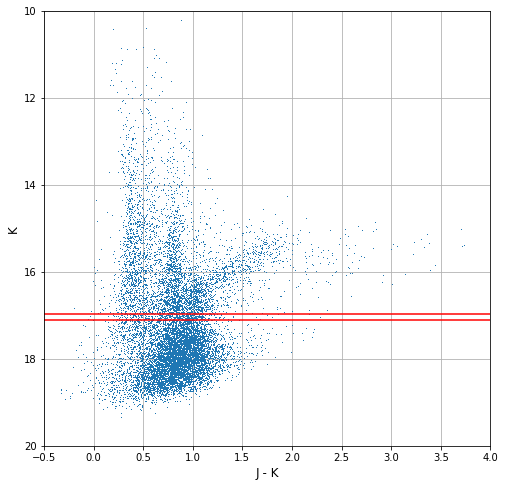

399
0.09368421052631579


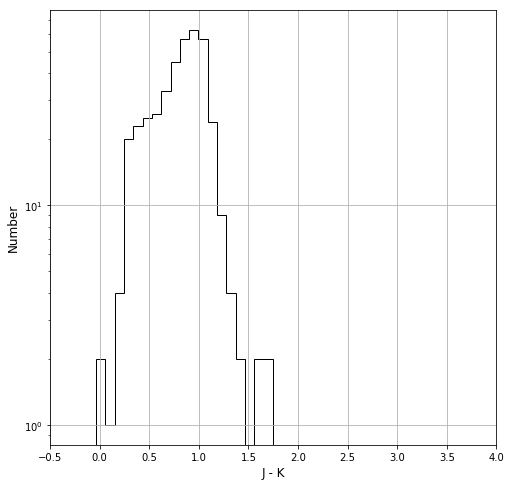

In [20]:
# 20

# Bin 1 (K = 17.100 to 16.963)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=17.100, linewidth=1.5, color='red') # Bin 1 - lower boundary
plt.axhline(y=16.963, linewidth=1.5, color='red') # Bin 1 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST1 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 17.100) & (low_error_jMINUSkDATA.Kmag > 16.963)]
#print jMINUSkHIST1
print len(jMINUSkHIST1)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST1.jMINUSk)
bin_number = (max(jMINUSkHIST1.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST1.jMINUSk, bins=np.arange(min(jMINUSkHIST1.jMINUSk), max(jMINUSkHIST1.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

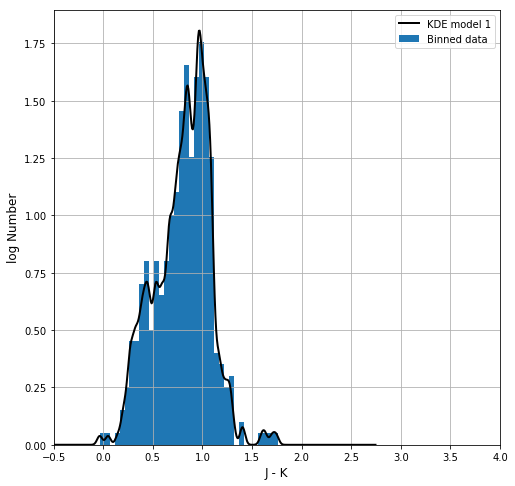

In [21]:
# 21

# Bin 1 (K = 17.100 to 16.963)
#
kde_data_1 = jMINUSkHIST1.jMINUSk[(jMINUSkHIST1.jMINUSk > -100.0) & (jMINUSkHIST1.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_1 ), max(kde_data_1 ) + 0.05, 0.05)
x_eval_1 = np.linspace(kde_data_1.min() - 1.0, kde_data_1.max() + 1.0, 500)
kde_1 = gaussian_kde(kde_data_1,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_1, kde_1(x_eval_1),'k',lw=2,label='KDE model 1')
plt.hist(kde_data_1,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.57, 0.65)
#plt.ylim(0.62, 0.70)
#plt.xlim(0.85, 0.96)
#plt.ylim(1.3, 1.42)
#plt.xlim(1.48,1.53)
#plt.ylim(0.0, 0.001)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 17.0315
### boundary 1: J-K = 0.60
### boundary 2: J-K = 0.91
### boundary 3: J-K = ---
### boundary 4: J-K = 1.50

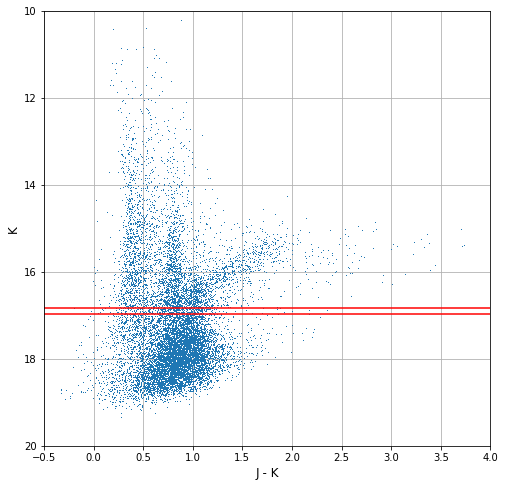

378
0.259125


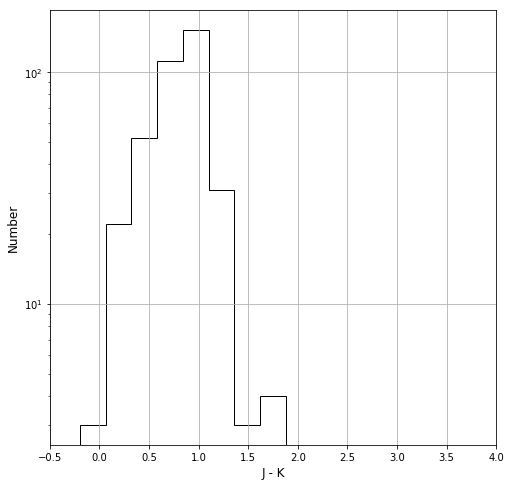

In [22]:
# 22

# Bin 2 (K = 16.963 to 16.826)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.963, linewidth=1.5, color='red') # Bin 2 - lower boundary
plt.axhline(y=16.826, linewidth=1.5, color='red') # Bin 2 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST2 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.963) & (low_error_jMINUSkDATA.Kmag > 16.826)]
#print jMINUSkHIST2
print len(jMINUSkHIST2)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST2.jMINUSk)
bin_number = (max(jMINUSkHIST2.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST2.jMINUSk, bins=np.arange(min(jMINUSkHIST2.jMINUSk), max(jMINUSkHIST2.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

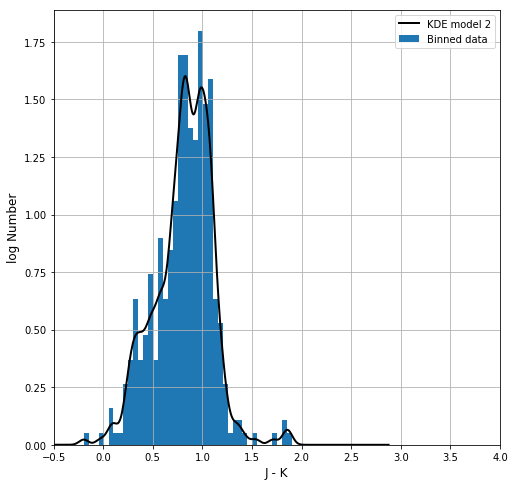

In [23]:
# 21

# Bin 2 (K = 16.963 to 16.826)
#
kde_data_2 = jMINUSkHIST2.jMINUSk[(jMINUSkHIST2.jMINUSk > -100.0) & (jMINUSkHIST2.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_2 ), max(kde_data_2 ) + 0.05, 0.05)
x_eval_2 = np.linspace(kde_data_2.min() - 1.0, kde_data_2.max() + 1.0, 500)
kde_2 = gaussian_kde(kde_data_2,bw_method=0.16)#binwidth) <- manually set
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_2, kde_2(x_eval_2),'k',lw=2,label='KDE model 2')
plt.hist(kde_data_2,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.51, 0.54)
#plt.ylim(0.63, 0.64)
#plt.xlim(0.85, 1.0)
#plt.ylim(1.25, 1.4)
#plt.xlim(1.7, 1.8)
#plt.ylim(0.0, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.8945
### boundary 1: J-K = 0.53
### boundary 2: J-K = 0.93
### boundary 3: J-K = ---
### boundary 4: J-K = 1.77

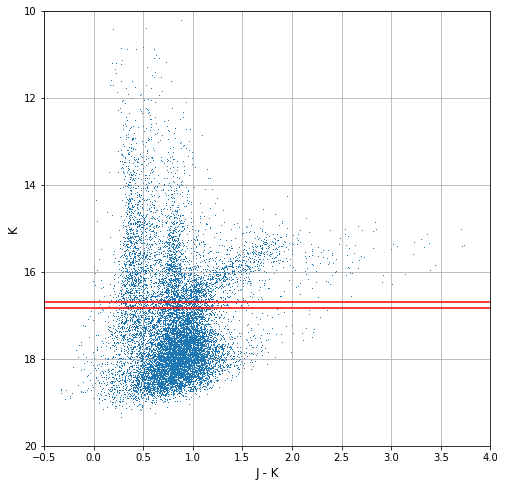

391
0.09088235294117647


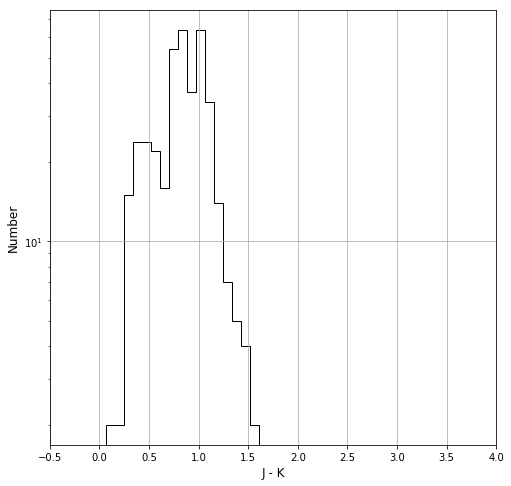

In [24]:
# 24

# Bin 3 (K = 16.826 to 16.689)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.826, linewidth=1.5, color='red') # Bin 3 - lower boundary
plt.axhline(y=16.689, linewidth=1.5, color='red') # Bin 3 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST3 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.826) & (low_error_jMINUSkDATA.Kmag > 16.689)]
#print jMINUSkHIST3
print len(jMINUSkHIST3)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST3.jMINUSk)
bin_number = (max(jMINUSkHIST3.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST3.jMINUSk, bins=np.arange(min(jMINUSkHIST3.jMINUSk), max(jMINUSkHIST3.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

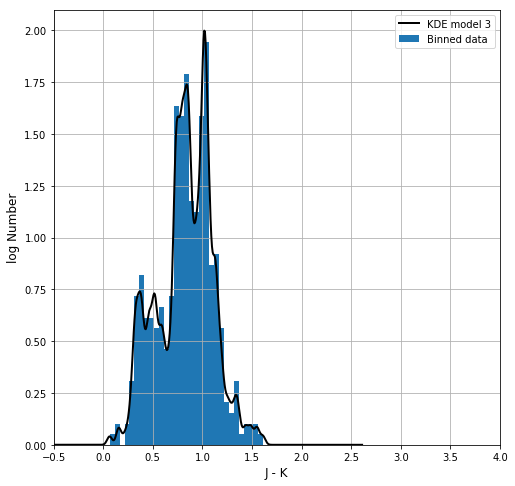

In [25]:
# 25

# Bin 3 (K = 16.826 to 16.689)
#
kde_data_3 = jMINUSkHIST3.jMINUSk[(jMINUSkHIST3.jMINUSk > -100.0) & (jMINUSkHIST3.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_3 ), max(kde_data_3 ) + 0.05, 0.05)
x_eval_3 = np.linspace(kde_data_3.min() - 1.0, kde_data_3.max() + 1.0, 500)
kde_3 = gaussian_kde(kde_data_3,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_3, kde_3(x_eval_3),'k',lw=2,label='KDE model 3')
plt.hist(kde_data_3,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.56, 0.61)
#plt.ylim(0.47, 0.56)
#plt.xlim(0.93, 0.96)
#plt.ylim(1.0, 1.22)
#plt.xlim(1.8, 1.85)
#plt.ylim(0.0, 0.02)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.7575
### boundary 1: J-K = 0.58
### boundary 2: J-K = 0.945
### boundary 3: J-K = ---
### boundary 4: J-K = 1.825

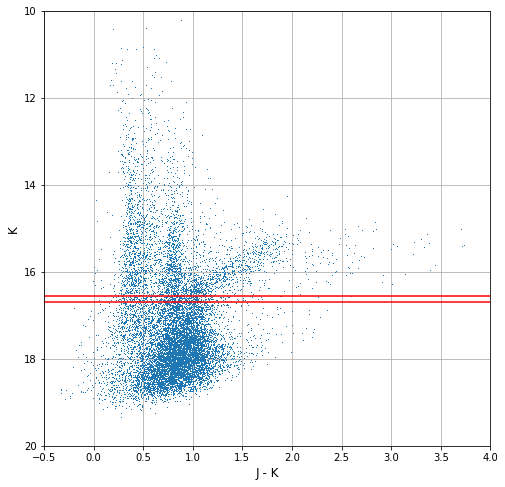

375
0.11449999999999999


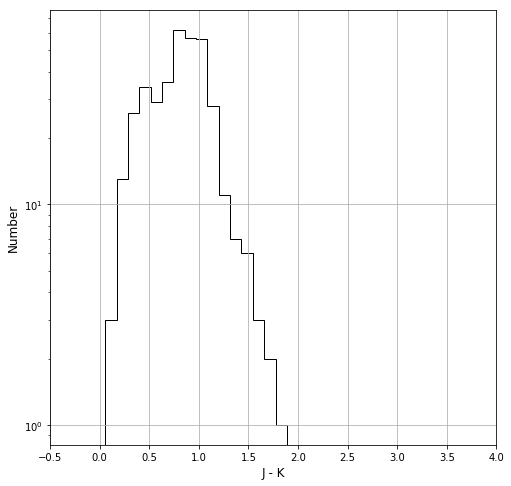

In [26]:
# 26

# Bin 4 (K = 16.689 to 16.552)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.689, linewidth=1.5, color='red') # Bin 4 - lower boundary
plt.axhline(y=16.552, linewidth=1.5, color='red') # Bin 4 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST4 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.689) & (low_error_jMINUSkDATA.Kmag > 16.552)]
#print jMINUSkHIST4
print len(jMINUSkHIST4)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST4.jMINUSk)
bin_number = (max(jMINUSkHIST4.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST4.jMINUSk, bins=np.arange(min(jMINUSkHIST4.jMINUSk), max(jMINUSkHIST4.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

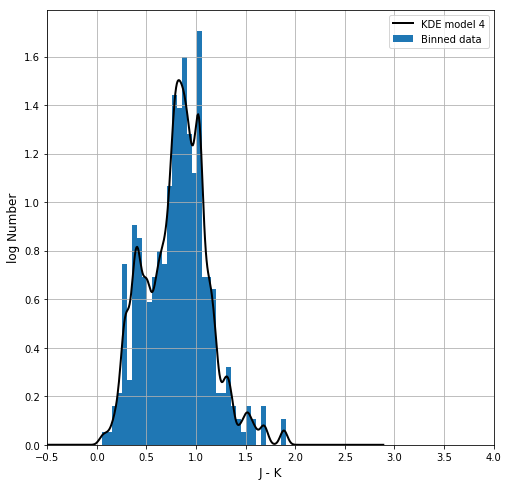

In [27]:
# 27

# Bin 4 (K = 16.689 to 16.552)
#
kde_data_4 = jMINUSkHIST4.jMINUSk[(jMINUSkHIST4.jMINUSk > -100.0) & (jMINUSkHIST4.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_4 ), max(kde_data_4 ) + 0.05, 0.05)
x_eval_4 = np.linspace(kde_data_4.min() - 1.0, kde_data_4.max() + 1.0, 500)
kde_4 = gaussian_kde(kde_data_4,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_4, kde_4(x_eval_4),'k',lw=2,label='KDE model 4')
plt.hist(kde_data_4,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.56, 0.62)
#plt.ylim(0.2, 0.5)
#plt.xlim(0.91, 0.95)
#plt.ylim(0.8, 0.95)
#plt.xlim(1.84, 1.86)
#plt.ylim(0.0, 0.02)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.6205
### boundary 1: J-K = 0.585
### boundary 2: J-K = 0.935
### boundary 3: J-K = ---
### boundary 4: J-K = 1.85

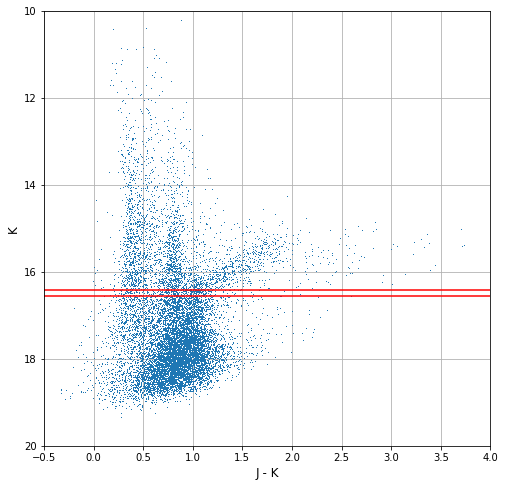

353
0.10416666666666669


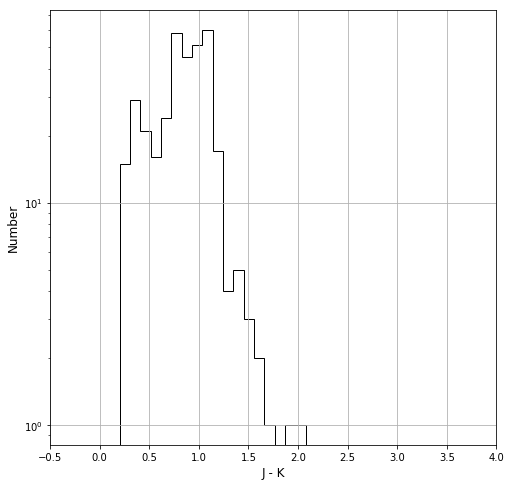

In [28]:
# 28

# Bin 5 (K = 16.552 to 16.415)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.552, linewidth=1.5, color='red') # Bin 5 - lower boundary
plt.axhline(y=16.415, linewidth=1.5, color='red') # Bin 5 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST5 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.552) & (low_error_jMINUSkDATA.Kmag > 16.415)]
#print jMINUSkHIST5
print len(jMINUSkHIST5)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST5.jMINUSk)
bin_number = (max(jMINUSkHIST5.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST5.jMINUSk, bins=np.arange(min(jMINUSkHIST5.jMINUSk), max(jMINUSkHIST5.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

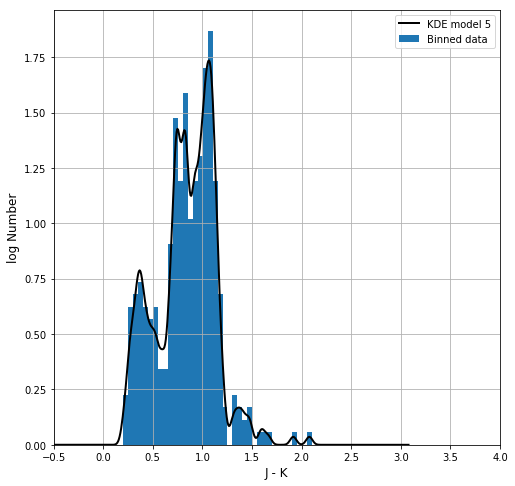

In [29]:
# 28

# Bin 5 (K = 16.552 to 16.415)
#
kde_data_5 = jMINUSkHIST5.jMINUSk[(jMINUSkHIST5.jMINUSk > -100.0) & (jMINUSkHIST5.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_5 ), max(kde_data_5 ) + 0.05, 0.05)
x_eval_5 = np.linspace(kde_data_5.min() - 1.0, kde_data_5.max() + 1.0, 500)
kde_5 = gaussian_kde(kde_data_5,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_5, kde_5(x_eval_5),'k',lw=2,label='KDE model 5')
plt.hist(kde_data_5,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.5, 0.65)
#plt.ylim(0.4, 0.6)
#plt.xlim(0.93, 0.97)
#plt.ylim(0.6, 0.8)
#plt.xlim(1.12, 1.14)
#plt.ylim(0.5, 0.6)
#plt.xlim(1.85, 1.99)
#plt.ylim(0.0, 0.04)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.4835
### boundary 1: J-K = 0.59
### boundary 2: J-K = 0.96
### boundary 3: J-K = 1.125
### boundary 4: J-K = 1.91

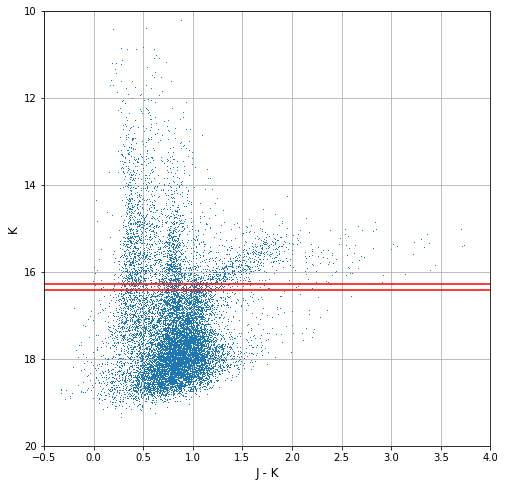

304
0.14787499999999998


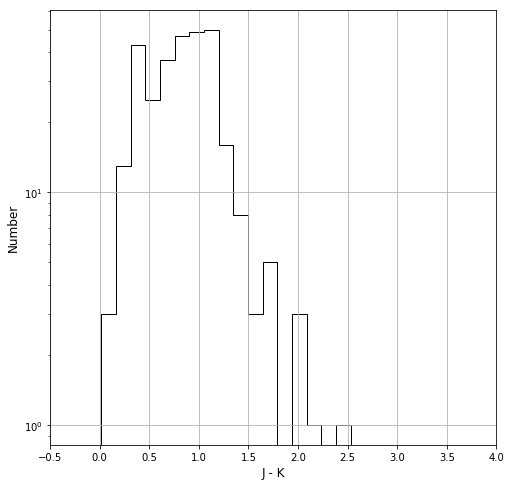

In [30]:
# 30

# Bin 6 (K = 16.415 to 16.278)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.415, linewidth=1.5, color='red') # Bin 6 - lower boundary
plt.axhline(y=16.278, linewidth=1.5, color='red') # Bin 6 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST6 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.415) & (low_error_jMINUSkDATA.Kmag > 16.278)]
#print jMINUSkHIST6
print len(jMINUSkHIST6)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST6.jMINUSk)
bin_number = (max(jMINUSkHIST6.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST6.jMINUSk, bins=np.arange(min(jMINUSkHIST6.jMINUSk), max(jMINUSkHIST6.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

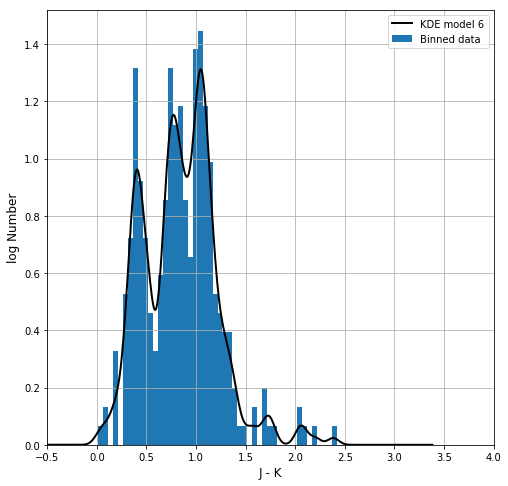

In [31]:
# 31

# Bin 6 (K = 16.415 to 16.278)
#
kde_data_6 = jMINUSkHIST6.jMINUSk[(jMINUSkHIST6.jMINUSk > -100.0) & (jMINUSkHIST6.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_6 ), max(kde_data_6 ) + 0.05, 0.05)
x_eval_6 = np.linspace(kde_data_6.min() - 1.0, kde_data_6.max() + 1.0, 500)
kde_6 = gaussian_kde(kde_data_6,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_6, kde_6(x_eval_6),'k',lw=2,label='KDE model 6')
plt.hist(kde_data_6,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.55, 0.65)
#plt.ylim(0.2, 0.5)
#plt.xlim(0.91, 0.95)
#plt.ylim(0.86, 0.9)
#plt.xlim(1.18, 1.28)
#plt.ylim(0.4, 0.55)
#plt.xlim(1.87, 1.93)
#plt.ylim(0.0, 0.001)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.3465
### boundary 1: J-K = 0.59
### boundary 2: J-K = 0.935
### boundary 3: J-K = 1.23
### boundary 4: J-K = 1.905

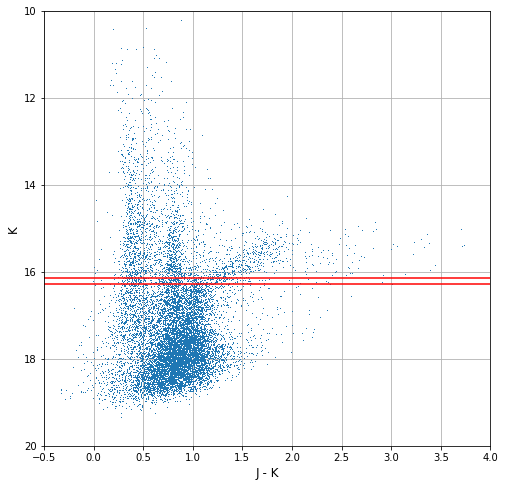

339
0.148375


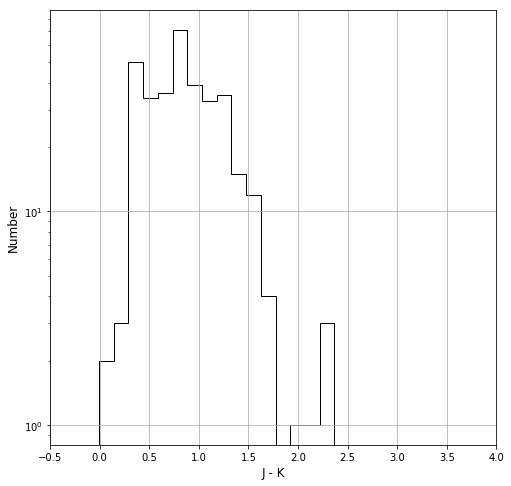

In [32]:
# 32

# Bin 7 (K = 16.278 to 16.141)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.278, linewidth=1.5, color='red') # Bin 7 - lower boundary
plt.axhline(y=16.141, linewidth=1.5, color='red') # Bin 7 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST7 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.278) & (low_error_jMINUSkDATA.Kmag > 16.141)]
#print jMINUSkHIST7
print len(jMINUSkHIST7)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST7.jMINUSk)
bin_number = (max(jMINUSkHIST7.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST7.jMINUSk, bins=np.arange(min(jMINUSkHIST7.jMINUSk), max(jMINUSkHIST7.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

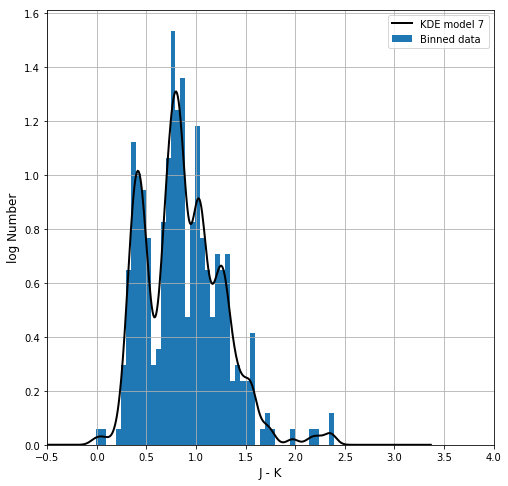

In [33]:
# 33

# Bin 7 (K = 16.278 to 16.141)
#
kde_data_7 = jMINUSkHIST7.jMINUSk[(jMINUSkHIST7.jMINUSk > -100.0) & (jMINUSkHIST7.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_7 ), max(kde_data_7 ) + 0.05, 0.05)
x_eval_7 = np.linspace(kde_data_7.min() - 1.0, kde_data_7.max() + 1.0, 500)
kde_7 = gaussian_kde(kde_data_7,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_7, kde_7(x_eval_7),'k',lw=2,label='KDE model 7')
plt.hist(kde_data_7,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.55, 0.62)
#plt.ylim(0.3, 0.5)
#plt.xlim(0.92, 0.96)
#plt.ylim(0.6, 0.8)
#plt.xlim(1.14, 1.17)
#plt.ylim(0.5, 0.56)
#plt.xlim(1.8, 1.95)
#plt.ylim(0.0, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.2095
### boundary 1: J-K = 0.585
### boundary 2: J-K = 0.94
### boundary 3: J-K = 1.16
### boundary 4: J-K = 1.87

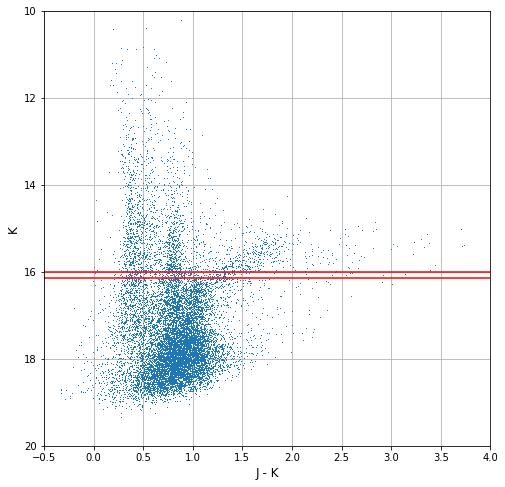

262
0.17260000000000003


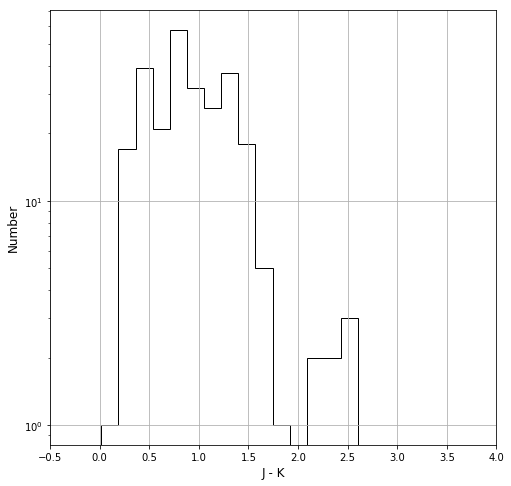

In [34]:
# 34

# Bin 8 (K = 16.141 to 16.004)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.141, linewidth=1.5, color='red') # Bin 8 - lower boundary
plt.axhline(y=16.004, linewidth=1.5, color='red') # Bin 8 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST8 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.141) & (low_error_jMINUSkDATA.Kmag > 16.004)]
#print jMINUSkHIST8
print len(jMINUSkHIST8)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST8.jMINUSk)
bin_number = (max(jMINUSkHIST8.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST8.jMINUSk, bins=np.arange(min(jMINUSkHIST8.jMINUSk), max(jMINUSkHIST8.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

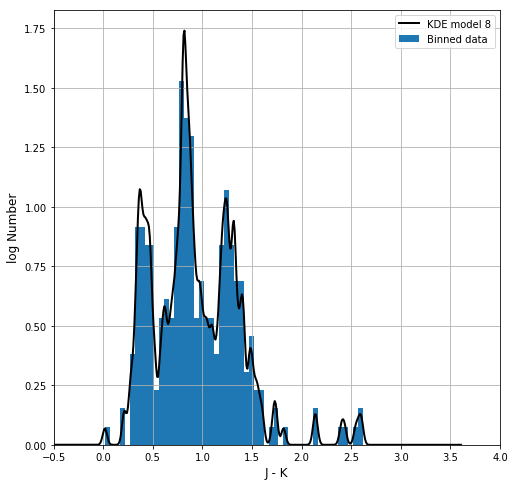

In [35]:
# 35

# Bin 8 (K = 16.141 to 16.004)
#
kde_data_8 = jMINUSkHIST8.jMINUSk[(jMINUSkHIST8.jMINUSk > -100.0) & (jMINUSkHIST8.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_8 ), max(kde_data_8 ) + 0.05, 0.05)
x_eval_8 = np.linspace(kde_data_8.min() - 1.0, kde_data_8.max() + 1.0, 500)
kde_8 = gaussian_kde(kde_data_8,bw_method=0.05)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_8, kde_8(x_eval_8),'k',lw=2,label='KDE model 8')
plt.hist(kde_data_8,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.5, 0.6)
#plt.ylim(0.15, 0.45)
#plt.xlim(0.9, 1.0)
#plt.ylim(0.55, 0.80)
#plt.xlim(1.05, 1.2)
#plt.ylim(0.4, 0.6)
#plt.xlim(1.88, 2.05)
#plt.ylim(0.0, 0.001)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 16.0725
### boundary 1: J-K = 0.55
### boundary 2: J-K = 0.95
### boundary 3: J-K = 1.13
### boundary 4: J-K = 1.97

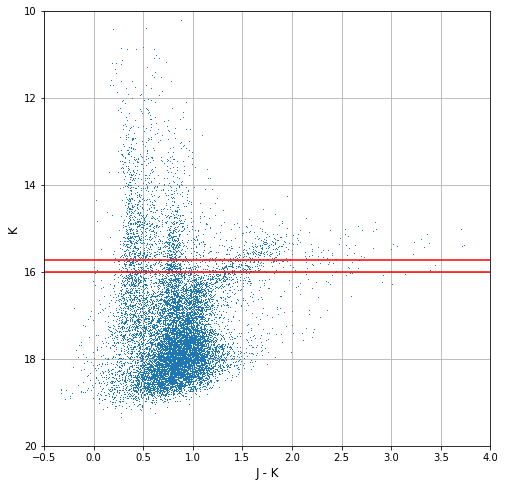

502
0.17779999999999999


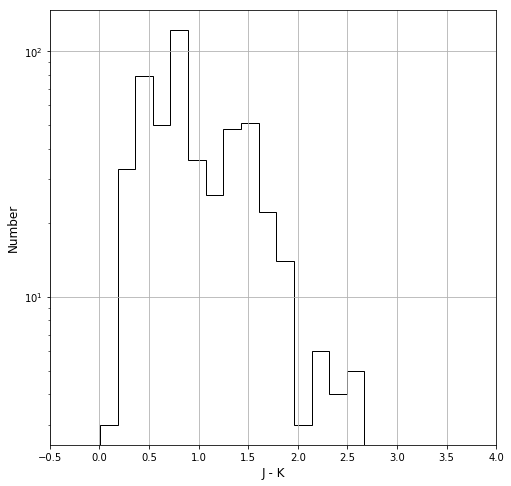

In [36]:
# 36

# Bin 9 (K = 16.004 to 15.730) <- start double-wide bins
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=16.004, linewidth=1.5, color='red') # Bin 9 - lower boundary
plt.axhline(y=15.730, linewidth=1.5, color='red') # Bin 9 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST9 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 16.004) & (low_error_jMINUSkDATA.Kmag > 15.730)]
#print jMINUSkHIST9
print len(jMINUSkHIST9)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST9.jMINUSk)
bin_number = (max(jMINUSkHIST9.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST9.jMINUSk, bins=np.arange(min(jMINUSkHIST9.jMINUSk), max(jMINUSkHIST9.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

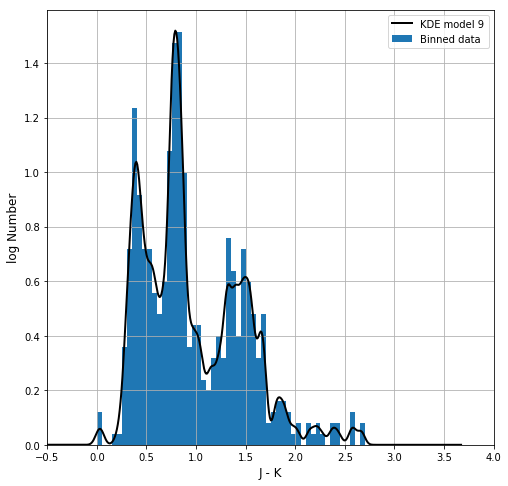

In [37]:
# 37

# Bin 9 (K = 16.004 to 15.730)
#
kde_data_9 = jMINUSkHIST9.jMINUSk[(jMINUSkHIST9.jMINUSk > -100.0) & (jMINUSkHIST9.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_9 ), max(kde_data_9 ) + 0.05, 0.05)
x_eval_9 = np.linspace(kde_data_9.min() - 1.0, kde_data_9.max() + 1.0, 500)
kde_9 = gaussian_kde(kde_data_9,bw_method=0.07)#binwidth) <- needed for extremely dusty sources
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_9, kde_9(x_eval_9),'k',lw=2,label='KDE model 9')
plt.hist(kde_data_9,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.6, 0.7)
#plt.ylim(0.5, 0.6)
#plt.xlim(0.86, 1.0)
#plt.ylim(0.38, 0.6)
#plt.xlim(1.05, 1.15)
#plt.ylim(0.25, 0.3)
#plt.xlim(2.05, 2.15)
#plt.ylim(0.0, 0.05)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.867
### boundary 1: J-K = 0.63
### boundary 2: J-K = 0.95
### boundary 3: J-K = 1.11
### boundary 4: J-K = 2.08

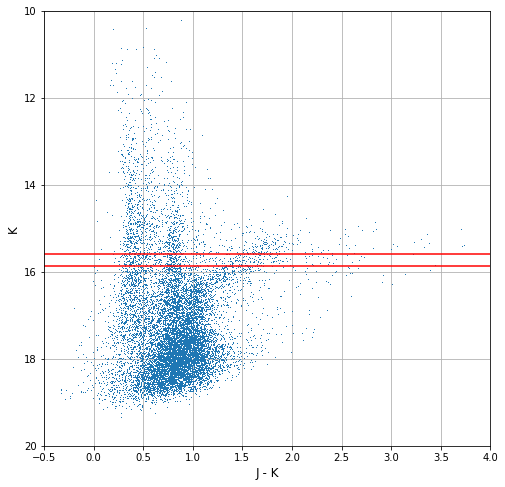

459
0.2229166666666667


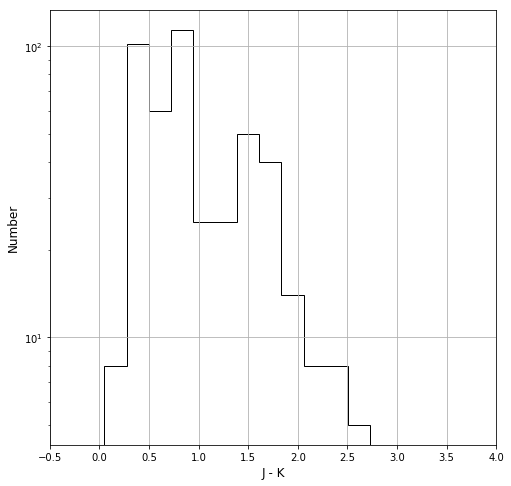

In [38]:
# 38

# Bin 10 (K = 15.867 to 15.593)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.867, linewidth=1.5, color='red') # Bin 10 - lower boundary
plt.axhline(y=15.593, linewidth=1.5, color='red') # Bin 10 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST10 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.867) & (low_error_jMINUSkDATA.Kmag > 15.593)]
#print jMINUSkHIST10
print len(jMINUSkHIST10)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST10.jMINUSk)
bin_number = (max(jMINUSkHIST10.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST10.jMINUSk, bins=np.arange(min(jMINUSkHIST10.jMINUSk), max(jMINUSkHIST10.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

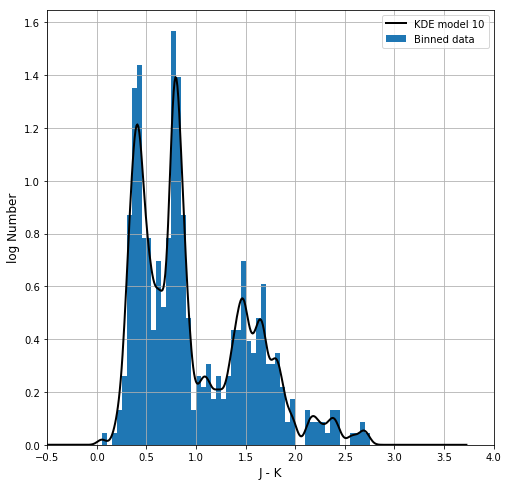

In [39]:
# 39

# Bin 10 (K = 15.867 to 15.593)
#
kde_data_10 = jMINUSkHIST10.jMINUSk[(jMINUSkHIST10.jMINUSk > -100.0) & (jMINUSkHIST10.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_10 ), max(kde_data_10 ) + 0.05, 0.05)
x_eval_10 = np.linspace(kde_data_10.min() - 1.0, kde_data_10.max() + 1.0, 500)
kde_10 = gaussian_kde(kde_data_10,bw_method=0.08)#binwidth) <- needed for extremely dusty sources
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_10, kde_10(x_eval_10),'k',lw=2,label='KDE model 10')
plt.hist(kde_data_10,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.6, 0.7)
#plt.ylim(0.3, 0.8)
#plt.xlim(0.98, 1.08)
#plt.ylim(0.2, 0.4)
#plt.xlim(1.18, 1.22)
#plt.ylim(0.20, 0.22)
#plt.xlim(2.02, 2.10)
#plt.ylim(0.03, 0.09)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.730
### boundary 1: J-K = 0.65
### boundary 2: J-K = 1.02
### boundary 3: J-K = 1.20
### boundary 4: J-K = 2.06

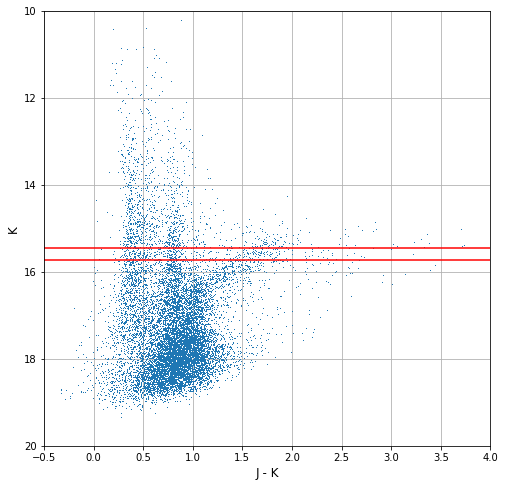

408
0.2658181818181818


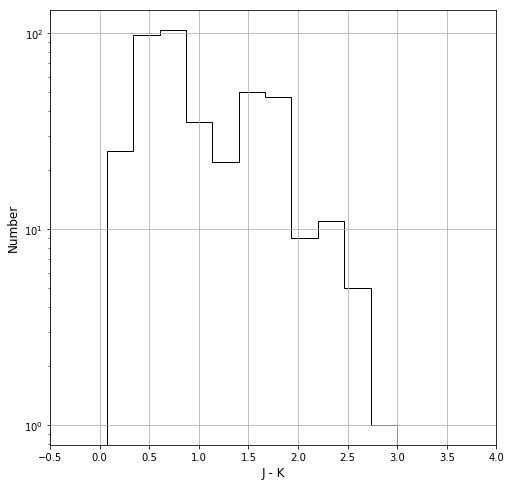

In [40]:
# 40

# Bin 11 (K = 15.730 to 15.456)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.730, linewidth=1.5, color='red') # Bin 11 - lower boundary
plt.axhline(y=15.456, linewidth=1.5, color='red') # Bin 11 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST11 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.730) & (low_error_jMINUSkDATA.Kmag > 15.456)]
#print jMINUSkHIST11
print len(jMINUSkHIST11)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST11.jMINUSk)
bin_number = (max(jMINUSkHIST11.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST11.jMINUSk, bins=np.arange(min(jMINUSkHIST11.jMINUSk), max(jMINUSkHIST11.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

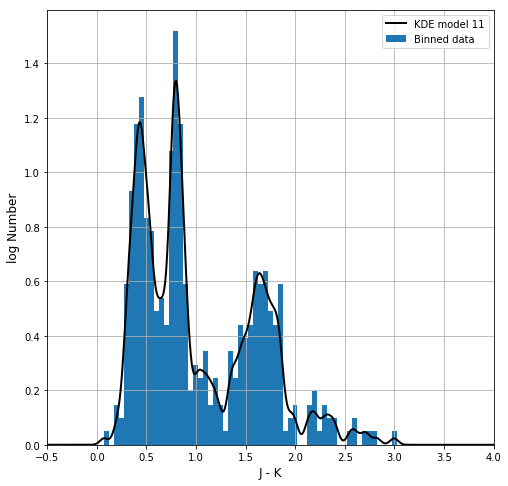

In [41]:
# 41

# Bin 11 (K = 15.730 to 15.456)
#
kde_data_11 = jMINUSkHIST11.jMINUSk[(jMINUSkHIST11.jMINUSk > -100.0) & (jMINUSkHIST11.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_11 ), max(kde_data_11 ) + 0.05, 0.05)
x_eval_11 = np.linspace(kde_data_11.min() - 1.0, kde_data_11.max() + 1.0, 500)
kde_11 = gaussian_kde(kde_data_11,bw_method=0.07)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_11, kde_11(x_eval_11),'k',lw=2,label='KDE model 11')
plt.hist(kde_data_11,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.63, 0.65)
#plt.ylim(0.535, 0.54)
#plt.xlim(0.95, 1.01)
#plt.ylim(0.2, 0.4)
#plt.xlim(1.24, 1.31)
#plt.ylim(0.1, 0.2)
#plt.xlim(2.02, 2.11)
#plt.ylim(0.0, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.593
### boundary 1: J-K = 0.642
### boundary 2: J-K = 0.99
### boundary 3: J-K = 1.27
### boundary 4: J-K = 2.06

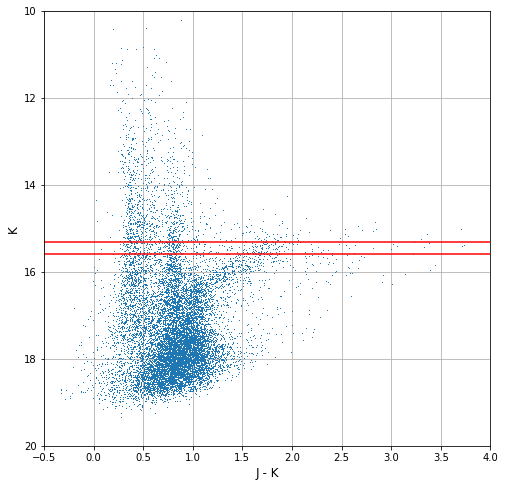

375
0.27599999999999997


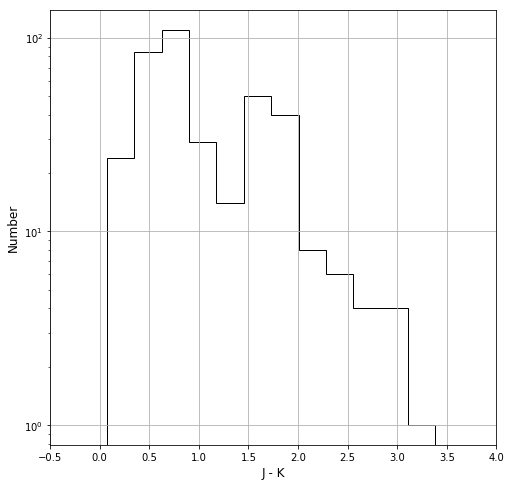

In [42]:
# 42

# Bin 12 (K = 15.593 to 15.319)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.593, linewidth=1.5, color='red') # Bin 12 - lower boundary
plt.axhline(y=15.319, linewidth=1.5, color='red') # Bin 12 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST12 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.593) & (low_error_jMINUSkDATA.Kmag > 15.319)]
#print jMINUSkHIST12
print len(jMINUSkHIST12)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST12.jMINUSk)
bin_number = (max(jMINUSkHIST12.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST12.jMINUSk, bins=np.arange(min(jMINUSkHIST12.jMINUSk), max(jMINUSkHIST12.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

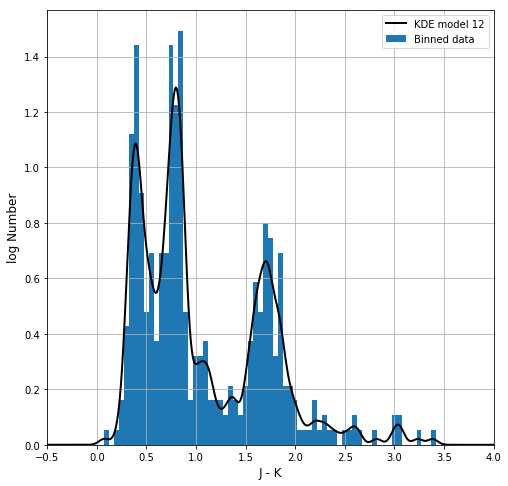

In [43]:
# 43

# Bin 12 (K = 15.593 to 15.319)
#
kde_data_12 = jMINUSkHIST12.jMINUSk[(jMINUSkHIST12.jMINUSk > -100.0) & (jMINUSkHIST12.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_12 ), max(kde_data_12 ) + 0.05, 0.05)
x_eval_12 = np.linspace(kde_data_12.min() - 1.0, kde_data_12.max() + 1.0, 500)
kde_12 = gaussian_kde(kde_data_12,bw_method=0.08)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_12, kde_12(x_eval_12),'k',lw=2,label='KDE model 12')
plt.hist(kde_data_12,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.55, 0.64)
#plt.ylim(0.5, 0.62)
#plt.xlim(0.9, 1.1)
#plt.ylim(0.2, 0.4)
#plt.xlim(1.22, 1.3)
#plt.ylim(0.1, 0.15)
#plt.xlim(2.1, 2.15)
#plt.ylim(0.05, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.456
### boundary 1: J-K = 0.595
### boundary 2: J-K = 1.00
### boundary 3: J-K = 1.255
### boundary 4: J-K = 2.12

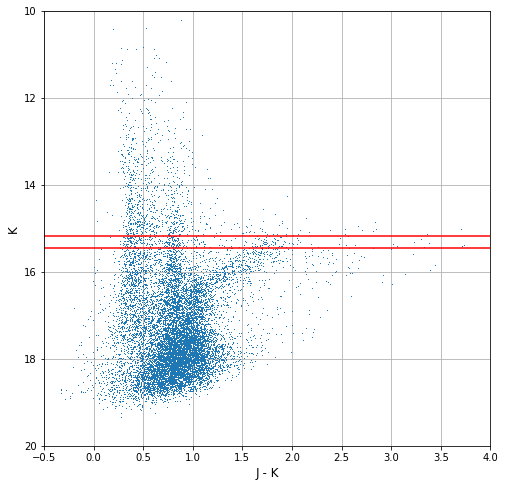

342
0.201125


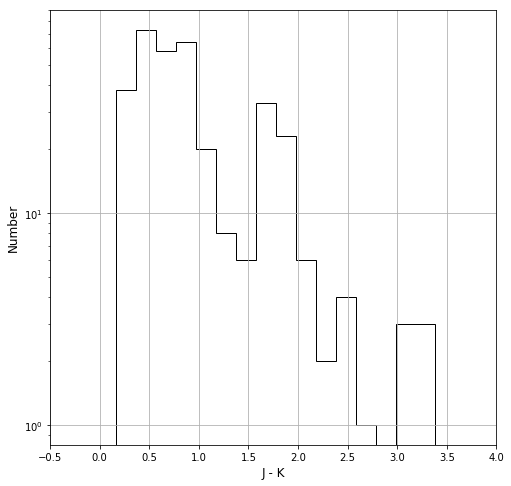

In [44]:
# 44

# Bin 13 (K = 15.456 to 15.182)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.456, linewidth=1.5, color='red') # Bin 13 - lower boundary
plt.axhline(y=15.182, linewidth=1.5, color='red') # Bin 13 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST13 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.456) & (low_error_jMINUSkDATA.Kmag > 15.182)]
#print jMINUSkHIST13
print len(jMINUSkHIST13)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST13.jMINUSk)
bin_number = (max(jMINUSkHIST13.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST13.jMINUSk, bins=np.arange(min(jMINUSkHIST13.jMINUSk), max(jMINUSkHIST13.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

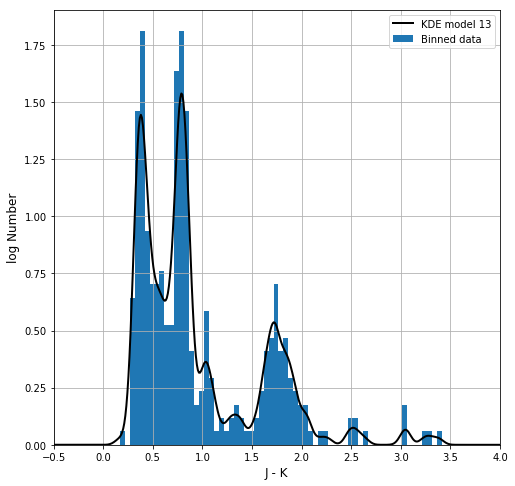

In [45]:
# 45

# Bin 13 (K = 15.456 to 15.182)
#
kde_data_13 = jMINUSkHIST13.jMINUSk[(jMINUSkHIST13.jMINUSk > -100.0) & (jMINUSkHIST13.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_13 ), max(kde_data_13 ) + 0.05, 0.05)
x_eval_13 = np.linspace(kde_data_13.min() - 1.0, kde_data_13.max() + 1.0, 500)
kde_13 = gaussian_kde(kde_data_13,bw_method=0.08)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_13, kde_13(x_eval_13),'k',lw=2,label='KDE model 13')
plt.hist(kde_data_13,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.55, 0.67)
#plt.ylim(0.5, 0.75)
#plt.xlim(0.94, 1.0)
#plt.ylim(0.3, 0.4)
#plt.xlim(1.20, 1.24)
#plt.ylim(0.08, 0.12)
#plt.xlim(2.15, 2.23)
#plt.ylim(0.03, 0.04)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.319
### boundary 1: J-K = 0.62
### boundary 2: J-K = 0.97
### boundary 3: J-K = 1.215
### boundary 4: J-K = 2.19

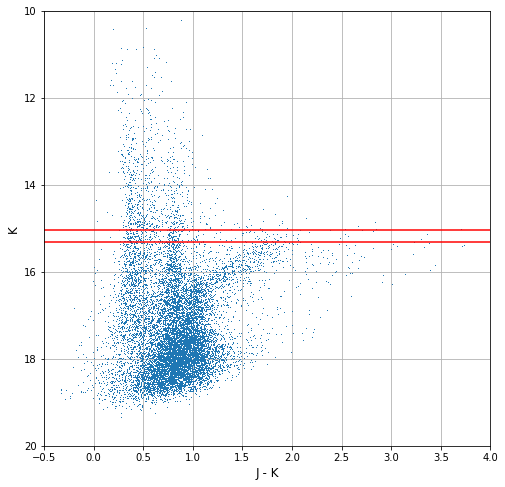

260
0.14504545454545453


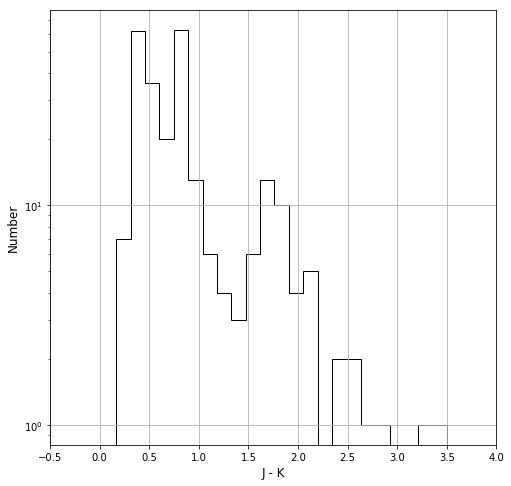

In [46]:
# 46

# Bin 14 (K = 15.319 to 15.045)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.319, linewidth=1.5, color='red') # Bin 14 - lower boundary
plt.axhline(y=15.045, linewidth=1.5, color='red') # Bin 14 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST14 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.319) & (low_error_jMINUSkDATA.Kmag > 15.045)]
#print jMINUSkHIST14
print len(jMINUSkHIST14)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST14.jMINUSk)
bin_number = (max(jMINUSkHIST14.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST14.jMINUSk, bins=np.arange(min(jMINUSkHIST14.jMINUSk), max(jMINUSkHIST14.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

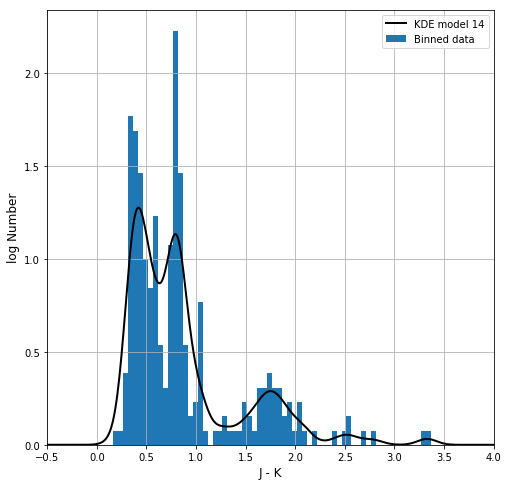

In [47]:
# 47

# Bin 14 (K = 15.319 to 15.045)
#
kde_data_14 = jMINUSkHIST14.jMINUSk[(jMINUSkHIST14.jMINUSk > -100.0) & (jMINUSkHIST14.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_14 ), max(kde_data_14 ) + 0.05, 0.05)
x_eval_14 = np.linspace(kde_data_14.min() - 1.0, kde_data_14.max() + 1.0, 500)
kde_14 = gaussian_kde(kde_data_14,bw_method=0.16)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_14, kde_14(x_eval_14),'k',lw=2,label='KDE model 14')
plt.hist(kde_data_14,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.60, 0.66)
#plt.ylim(0.85, 0.9)
#plt.xlim(0.94, 0.98)
#plt.ylim(0.4, 0.7)
#plt.xlim(1.28, 1.35)
#plt.ylim(0.095, 0.105)
#plt.xlim(2.15, 2.35)
#plt.ylim(0.0, 0.02)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.182
### boundary 1: J-K = 0.635
### boundary 2: J-K = 0.965
### boundary 3: J-K = 1.320
### boundary 4: J-K = 2.275

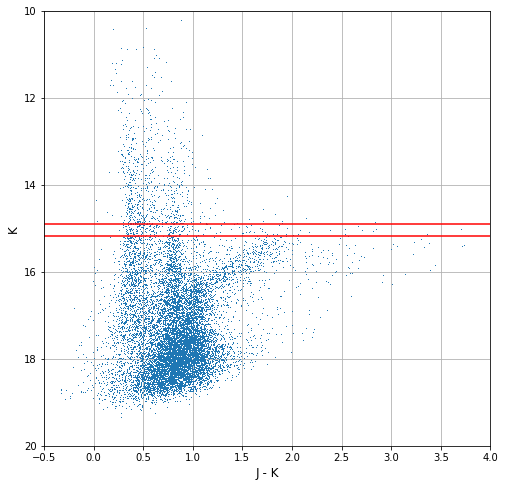

218
0.123


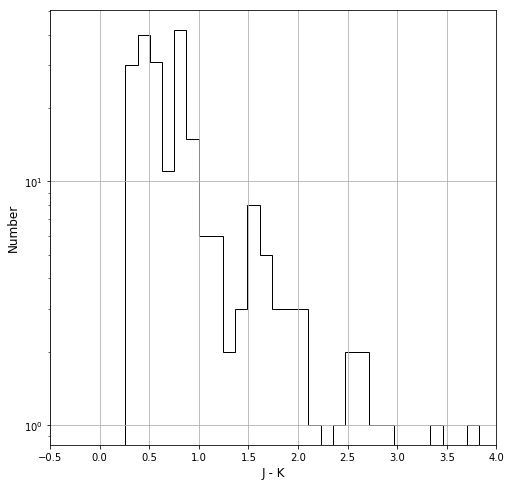

In [48]:
# 48

# Bin 15 (K = 15.182 to 14.908)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.182, linewidth=1.5, color='red') # Bin 15 - lower boundary
plt.axhline(y=14.908, linewidth=1.5, color='red') # Bin 15 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST15 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.182) & (low_error_jMINUSkDATA.Kmag > 14.908)]
#print jMINUSkHIST15
print len(jMINUSkHIST15)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST15.jMINUSk)
bin_number = (max(jMINUSkHIST15.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST15.jMINUSk, bins=np.arange(min(jMINUSkHIST15.jMINUSk), max(jMINUSkHIST15.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

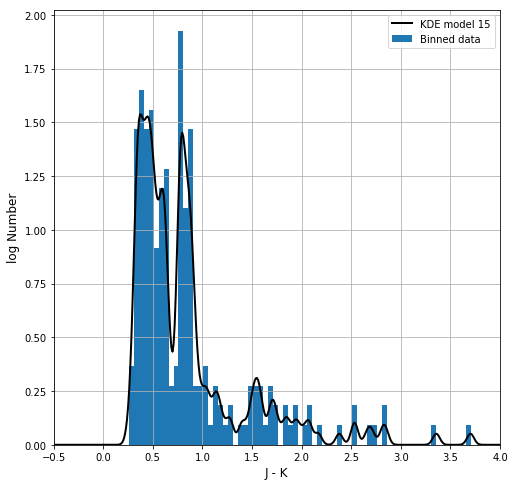

In [49]:
# 49

# Bin 15 (K = 15.182 to 14.908)
#
kde_data_15 = jMINUSkHIST15.jMINUSk[(jMINUSkHIST15.jMINUSk > -100.0) & (jMINUSkHIST15.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_15 ), max(kde_data_15 ) + 0.05, 0.05)
x_eval_15 = np.linspace(kde_data_15.min() - 1.0, kde_data_15.max() + 1.0, 500)
kde_15 = gaussian_kde(kde_data_15,bw_method=0.06)#binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_15, kde_15(x_eval_15),'k',lw=2,label='KDE model 15')
plt.hist(kde_data_15,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.65, 0.75)
#plt.ylim(0.25, 0.6)
#plt.xlim(0.98, 1.03)
#plt.ylim(0.25, 0.3)
#plt.xlim(1.34, 1.35)
#plt.ylim(0.04, 0.08)
#plt.xlim(2.22, 2.32)
#plt.ylim(0.0, 0.02)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 15.045
### boundary 1: J-K = 0.70
### boundary 2: J-K = 1.005
### boundary 3: J-K = 1.343
### boundary 4: J-K = 2.27

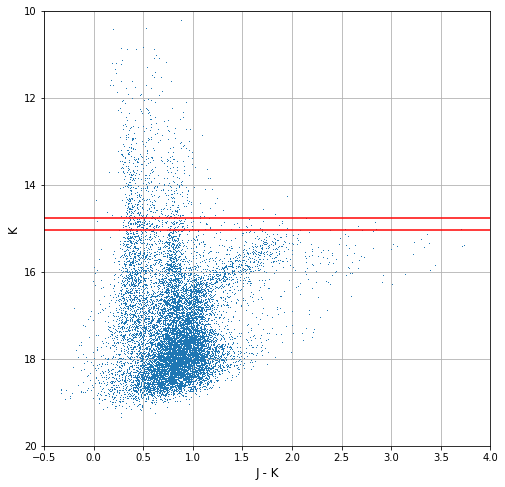

199
0.1264137931034483


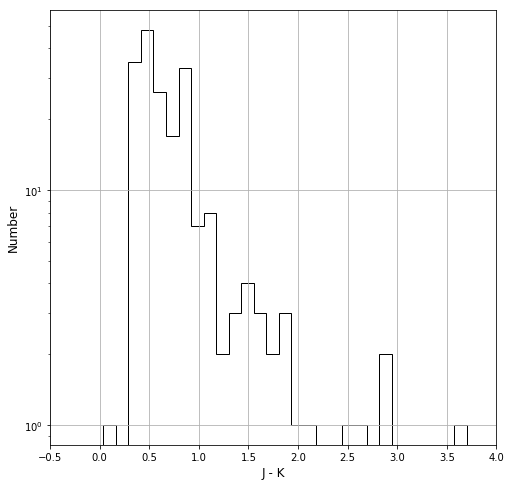

In [50]:
# 50

# Bin 16 (K = 15.045 to 14.771)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=15.045, linewidth=1.5, color='red') # Bin 16 - lower boundary
plt.axhline(y=14.771, linewidth=1.5, color='red') # Bin 16 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST16 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 15.045) & (low_error_jMINUSkDATA.Kmag > 14.771)]
#print jMINUSkHIST16
print len(jMINUSkHIST16)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST16.jMINUSk)
bin_number = (max(jMINUSkHIST16.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST16.jMINUSk, bins=np.arange(min(jMINUSkHIST16.jMINUSk), max(jMINUSkHIST16.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

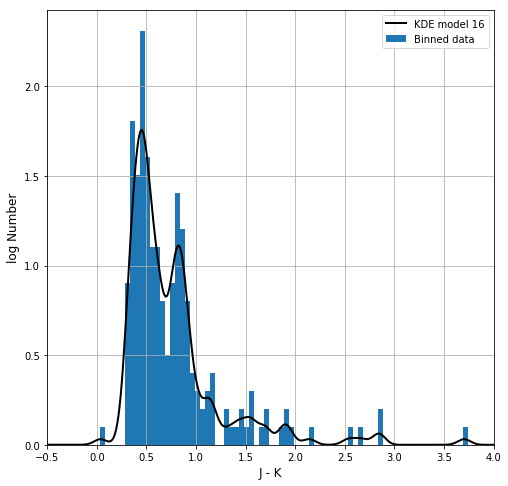

In [51]:
# 51

# Bin 16 (K = 15.045 to 14.771)
#
kde_data_16 = jMINUSkHIST16.jMINUSk[(jMINUSkHIST16.jMINUSk > -100.0) & (jMINUSkHIST16.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_16 ), max(kde_data_16 ) + 0.05, 0.05)
x_eval_16 = np.linspace(kde_data_16.min() - 1.0, kde_data_16.max() + 1.0, 500)
kde_16 = gaussian_kde(kde_data_16,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_16, kde_16(x_eval_16),'k',lw=2,label='KDE model 16')
plt.hist(kde_data_16,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.68, 0.72)
#plt.ylim(0.7, 0.75)
#plt.xlim(1.04, 1.08)
#plt.ylim(0.2, 0.4)
#plt.xlim(1.22, 1.3)
#plt.ylim(0.05, 0.1)
#plt.xlim(2.32, 2.36)
#plt.ylim(0.0, 0.0002)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 14.908
### boundary 1: J-K = 0.705
### boundary 2: J-K = 1.06
### boundary 3: J-K = 1.26
### boundary 4: J-K = 2.34

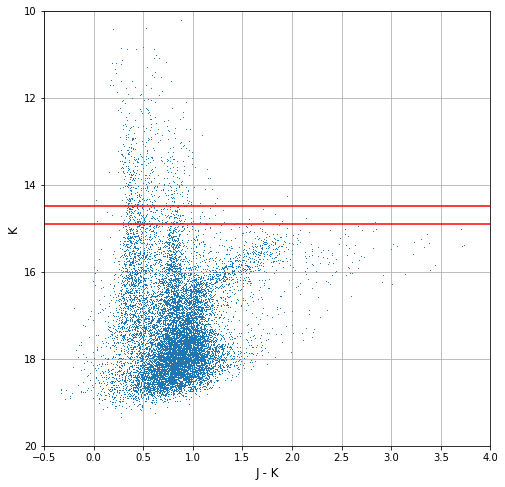

217
0.1474736842105263


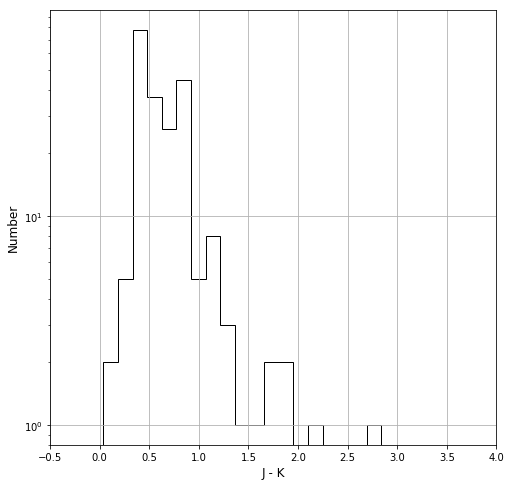

In [52]:
# 52

# Bin 17 (K = 14.908 to 14.497) <- start triple-wide bins
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=14.908, linewidth=1.5, color='red') # Bin 17 - lower boundary
plt.axhline(y=14.497, linewidth=1.5, color='red') # Bin 17 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST17 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 14.908) & (low_error_jMINUSkDATA.Kmag > 14.497)]
#print jMINUSkHIST17
print len(jMINUSkHIST17)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST17.jMINUSk)
bin_number = (max(jMINUSkHIST17.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST17.jMINUSk, bins=np.arange(min(jMINUSkHIST17.jMINUSk), max(jMINUSkHIST17.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

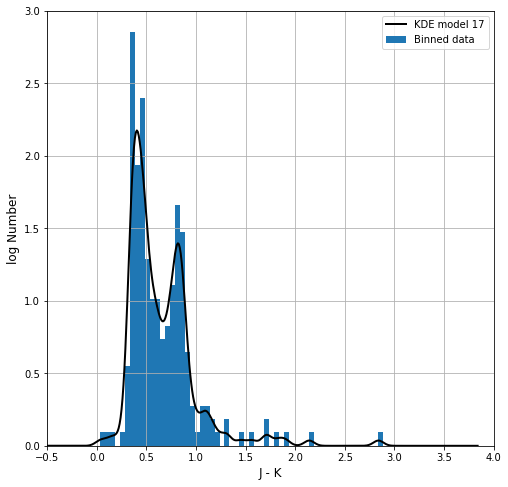

In [53]:
# 53

# Bin 17 (K = 14.908 to 14.497) <- start triple-wide bins
#
kde_data_17 = jMINUSkHIST17.jMINUSk[(jMINUSkHIST17.jMINUSk > -100.0) & (jMINUSkHIST17.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_17 ), max(kde_data_17 ) + 0.05, 0.05)
x_eval_17 = np.linspace(kde_data_17.min() - 1.0, kde_data_17.max() + 1.0, 500)
kde_17 = gaussian_kde(kde_data_17,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_17, kde_17(x_eval_17),'k',lw=2,label='KDE model 17')
plt.hist(kde_data_17,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.625, 0.7)
#plt.ylim(0.75, 0.82)
#plt.xlim(1.0, 1.07)
#plt.ylim(0.15, 0.3)
#plt.xlim(1.2, 1.3)
#plt.ylim(0.0, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 14.703
### boundary 1: J-K = 0.665
### boundary 2: J-K = 1.03
### boundary 3: J-K = 1.25
### boundary 4: J-K = 2.5

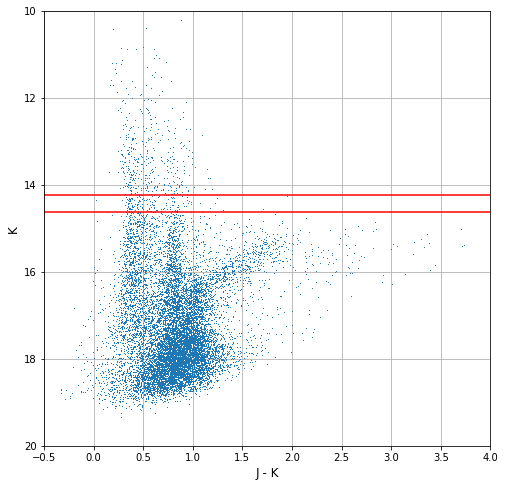

166
0.1375714285714286


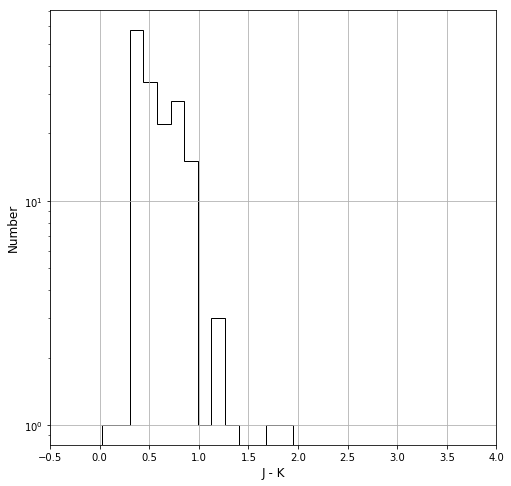

In [54]:
# 54

# Bin 18 (K = 14.634 to 14.223)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=14.634, linewidth=1.5, color='red') # Bin 18 - lower boundary
plt.axhline(y=14.223, linewidth=1.5, color='red') # Bin 18 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST18 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 14.634) & (low_error_jMINUSkDATA.Kmag > 14.223)]
#print jMINUSkHIST18
print len(jMINUSkHIST18)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST18.jMINUSk)
bin_number = (max(jMINUSkHIST18.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST18.jMINUSk, bins=np.arange(min(jMINUSkHIST18.jMINUSk), max(jMINUSkHIST18.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

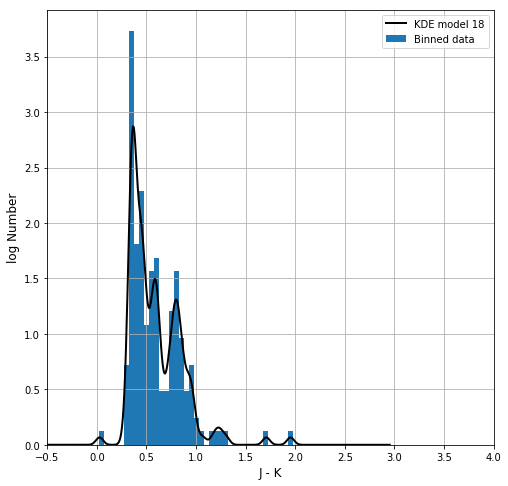

In [55]:
#55

# Bin 18 (K = 14.634 to 14.223)
#
kde_data_18 = jMINUSkHIST18.jMINUSk[(jMINUSkHIST18.jMINUSk > -100.0) & (jMINUSkHIST18.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_18 ), max(kde_data_18 ) + 0.05, 0.05)
x_eval_18 = np.linspace(kde_data_18.min() - 1.0, kde_data_18.max() + 1.0, 500)
kde_18 = gaussian_kde(kde_data_18,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_18, kde_18(x_eval_18),'k',lw=2,label='KDE model 18')
plt.hist(kde_data_18,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.65, 0.71)
#plt.ylim(0.45, 0.6)
#plt.xlim(1.0, 1.06)
#plt.ylim(0.0, 0.2)
#plt.xlim(1.3, 1.5)
#plt.ylim(0.0, 0.01)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 14.429
### boundary 1: J-K = 0.68
### boundary 2: J-K = 1.035
### boundary 3: J-K = 1.40
### boundary 4: J-K = ---

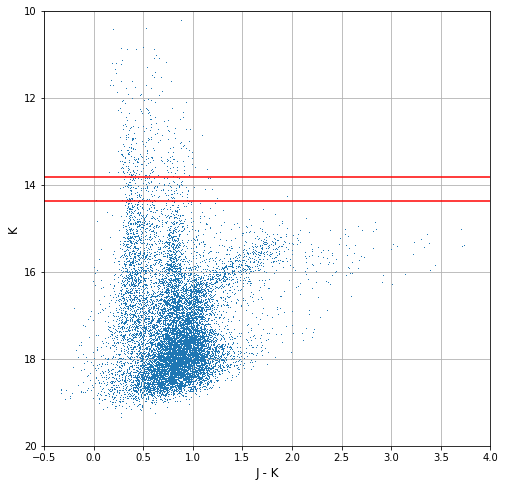

160
0.14024999999999999


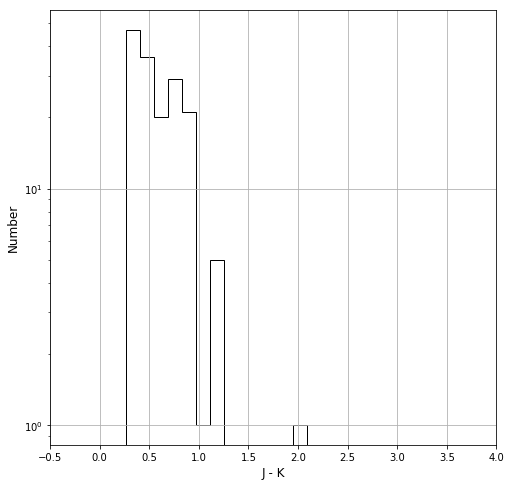

In [56]:
# 56

# Bin 19 (K = 14.360 to 13.812) <- start quadruple-wide bins
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=14.360, linewidth=1.5, color='red') # Bin 19 - lower boundary
plt.axhline(y=13.812, linewidth=1.5, color='red') # Bin 19 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST19 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 14.360) & (low_error_jMINUSkDATA.Kmag > 13.812)]
#print jMINUSkHIST19
print len(jMINUSkHIST19)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST19.jMINUSk)
bin_number = (max(jMINUSkHIST19.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST19.jMINUSk, bins=np.arange(min(jMINUSkHIST19.jMINUSk), max(jMINUSkHIST19.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

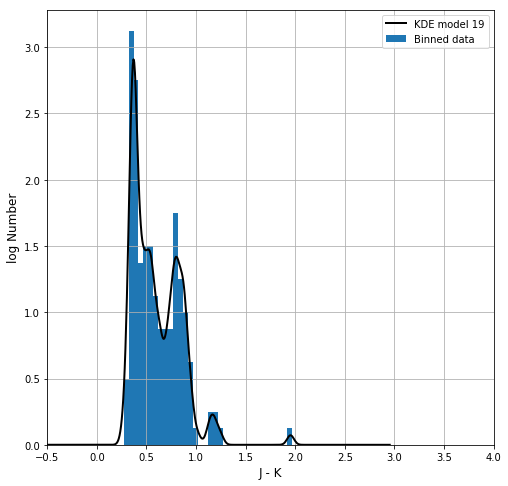

In [57]:
# 57

# Bin 19 (K = 14.360 to 13.812) <- start quadruple-wide bins
#
kde_data_19 = jMINUSkHIST19.jMINUSk[(jMINUSkHIST19.jMINUSk > -100.0) & (jMINUSkHIST19.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_19 ), max(kde_data_19 ) + 0.05, 0.05)
x_eval_19 = np.linspace(kde_data_19.min() - 1.0, kde_data_19.max() + 1.0, 500)
kde_19 = gaussian_kde(kde_data_19,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_19, kde_19(x_eval_19),'k',lw=2,label='KDE model 19')
plt.hist(kde_data_19,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.65, 0.7)
#plt.ylim(0.65, 0.8)
#plt.xlim(1.0, 1.15)
#plt.ylim(0.0, 0.2)
#plt.xlim(1.3, 1.4)
#plt.ylim(0.0, 0.001)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 14.086
### boundary 1: J-K = 0.675
### boundary 2: J-K = 1.07
### boundary 3: J-K = 1.34
### boundary 4: J-K = ---

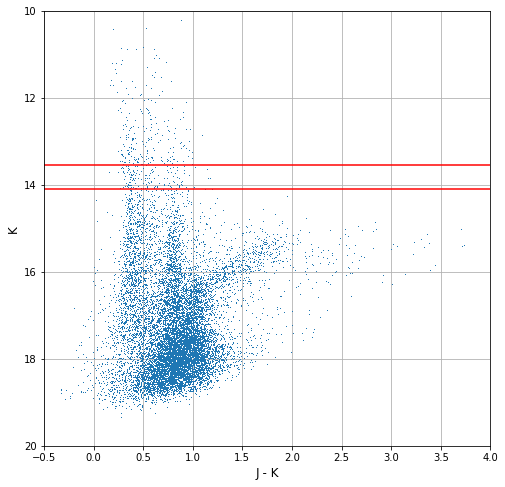

136
0.12762500000000002


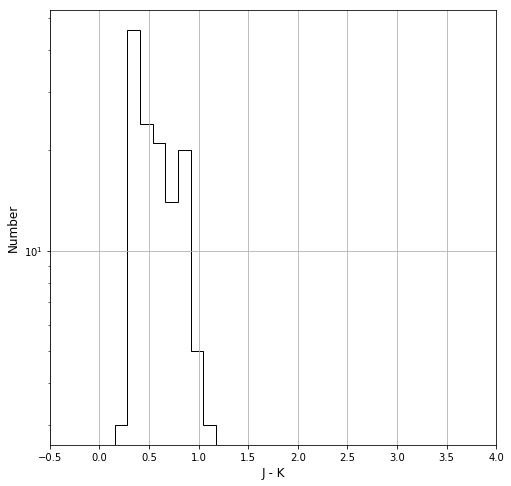

In [58]:
# 58

# Bin 20 (K = 14.086 to 13.538)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=14.086, linewidth=1.5, color='red') # Bin 20 - lower boundary
plt.axhline(y=13.538, linewidth=1.5, color='red') # Bin 20 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST20 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 14.086) & (low_error_jMINUSkDATA.Kmag > 13.538)]
#print jMINUSkHIST20
print len(jMINUSkHIST20)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST20.jMINUSk)
bin_number = (max(jMINUSkHIST20.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST20.jMINUSk, bins=np.arange(min(jMINUSkHIST20.jMINUSk), max(jMINUSkHIST20.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

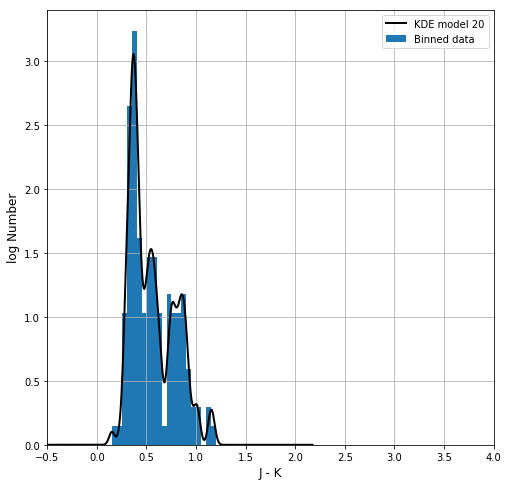

In [59]:
# 59

# Bin 20 (K = 14.086 to 13.538)
#
kde_data_20 = jMINUSkHIST20.jMINUSk[(jMINUSkHIST20.jMINUSk > -100.0) & (jMINUSkHIST20.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_20 ), max(kde_data_20 ) + 0.05, 0.05)
x_eval_20 = np.linspace(kde_data_20.min() - 1.0, kde_data_20.max() + 1.0, 500)
kde_20 = gaussian_kde(kde_data_20,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_20, kde_20(x_eval_20),'k',lw=2,label='KDE model 20')
plt.hist(kde_data_20,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.65, 0.72)
#plt.ylim(0.1, 0.6)
#plt.xlim(1.06, 1.1)
#plt.ylim(0.0, 0.04)
#plt.xlim(1.2, 1.3)
#plt.ylim(0.0, 0.01)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 13.812
### boundary 1: J-K = 0.68
### boundary 2: J-K = 1.085
### boundary 3: J-K = 1.25
### boundary 4: J-K = ---

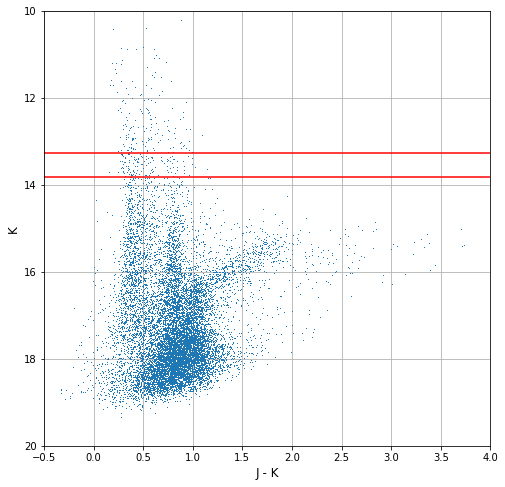

125
0.12362500000000001


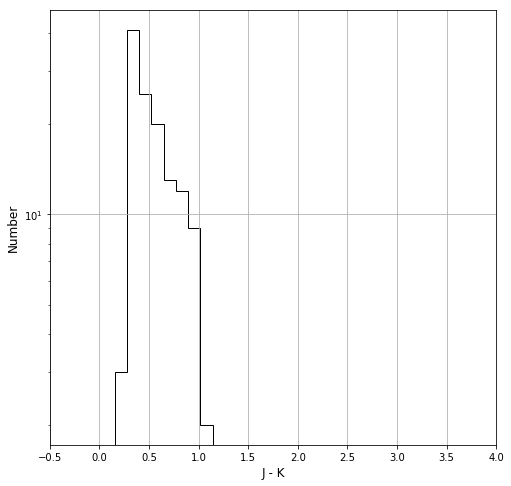

In [60]:
# 60

# Bin 21 (K = 13.812 to 13.264)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=13.812, linewidth=1.5, color='red') # Bin 21 - lower boundary
plt.axhline(y=13.264, linewidth=1.5, color='red') # Bin 21 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST21 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 13.812) & (low_error_jMINUSkDATA.Kmag > 13.264)]
#print jMINUSkHIST21
print len(jMINUSkHIST21)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST21.jMINUSk)
bin_number = (max(jMINUSkHIST21.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST21.jMINUSk, bins=np.arange(min(jMINUSkHIST21.jMINUSk), max(jMINUSkHIST21.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

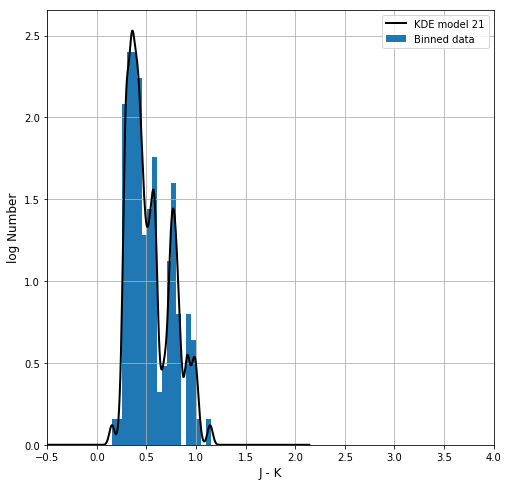

In [61]:
# 61

# Bin 21 (K = 13.812 to 13.264)
#
kde_data_21 = jMINUSkHIST21.jMINUSk[(jMINUSkHIST21.jMINUSk > -100.0) & (jMINUSkHIST21.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_21 ), max(kde_data_21 ) + 0.05, 0.05)
x_eval_21 = np.linspace(kde_data_21.min() - 1.0, kde_data_21.max() + 1.0, 500)
kde_21 = gaussian_kde(kde_data_21,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_21, kde_21(x_eval_21),'k',lw=2,label='KDE model 21')
plt.hist(kde_data_21,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.62, 0.68)
#plt.ylim(0.37, 0.43)
#plt.xlim(1.05, 1.15)
#plt.ylim(0.0, 0.03)
#plt.xlim(1.15, 1.3)
#plt.ylim(0.0, 0.01)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 13.538
### boundary 1: J-K = 0.645
### boundary 2: J-K = 1.08
### boundary 3: J-K = 1.22
### boundary 4: J-K = ---

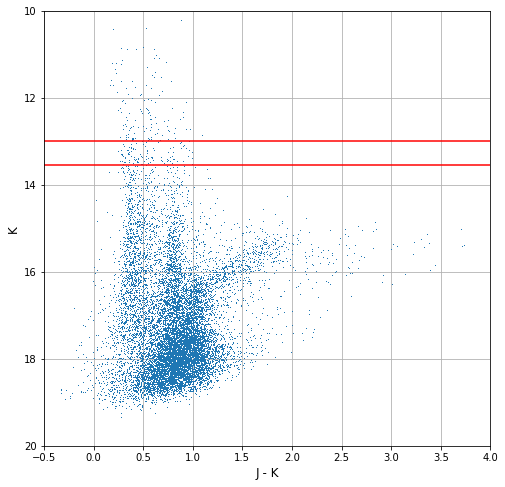

98
0.14800000000000002


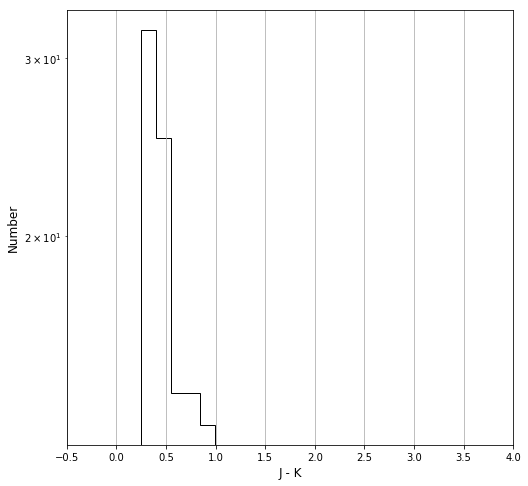

In [62]:
# 62

# Bin 22 (K = 13.538 to 12.990)
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
plt.axhline(y=13.538, linewidth=1.5, color='red') # Bin 22 - lower boundary
plt.axhline(y=12.990, linewidth=1.5, color='red') # Bin 22 - upper boundary
#
plt.grid(True)
plt.show()
plt.close()

# define the range of K-band magnitudes over which the bin is sampling
# from the catalog of sources with K-mag and J-mag errors less than 0.1.
#
jMINUSkHIST22 = low_error_jMINUSkDATA[(low_error_jMINUSkDATA.Kmag < 13.538) & (low_error_jMINUSkDATA.Kmag > 12.990)]
#print jMINUSkHIST22
print len(jMINUSkHIST22)
#
binwidth = stats.knuth_bin_width(jMINUSkHIST22.jMINUSk)
bin_number = (max(jMINUSkHIST22.jMINUSk)+binwidth)/binwidth
print binwidth
#print bin_number
#
fig = plt.figure(figsize = (8,8))
plt.hist(jMINUSkHIST22.jMINUSk, bins=np.arange(min(jMINUSkHIST22.jMINUSk), max(jMINUSkHIST22.jMINUSk) + binwidth, binwidth), histtype='step', color='black')
plt.yscale('log', nonposy='clip')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.0, 2.5)
#plt.ylim(0.0, 200.0)
plt.xlabel('J - K', size=12)
plt.ylabel('Number', size=12)
plt.grid(True)
plt.show()
plt.close()

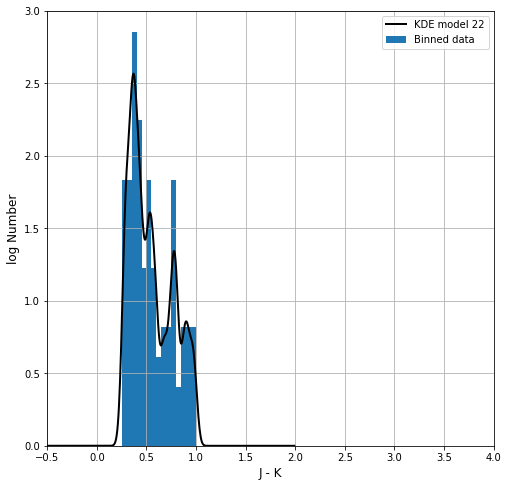

In [63]:
# 63

# Bin 22 (K = 13.538 to 12.990)
#
kde_data_22 = jMINUSkHIST22.jMINUSk[(jMINUSkHIST22.jMINUSk > -100.0) & (jMINUSkHIST22.jMINUSk < 5.0)].values
bins=np.arange(min(kde_data_22 ), max(kde_data_22 ) + 0.05, 0.05)
x_eval_22 = np.linspace(kde_data_22.min() - 1.0, kde_data_22.max() + 1.0, 500)
kde_22 = gaussian_kde(kde_data_22,bw_method=binwidth)
#
plt.figure(figsize=(8,8))
plt.plot(x_eval_22, kde_22(x_eval_22),'k',lw=2,label='KDE model 22')
plt.hist(kde_data_22,bins=bins,normed=True,label='Binned data')
plt.xlim(-0.5, 4.0)
#plt.xlim(0.6, 0.7)
#plt.ylim(0.4, 0.7)
#plt.xlim(1.0, 1.1)
#plt.ylim(0.0, 0.1)
plt.legend()
plt.xlabel('J - K', size=12)
plt.ylabel('log Number', size=12)
plt.grid(True)
plt.show()
plt.close()
#
### y-intercept: K = 13.264
### boundary 1: J-K = 0.635
### boundary 2: J-K = 1.05
### boundary 3: J-K = ---
### boundary 4: J-K = ---

In [64]:
# 64

# Phew!
#
# Next I have to zoom in and figure out the coordinates for
# each of the inflection points to divide up the four different
# populations of interesting objects in these CMDs.

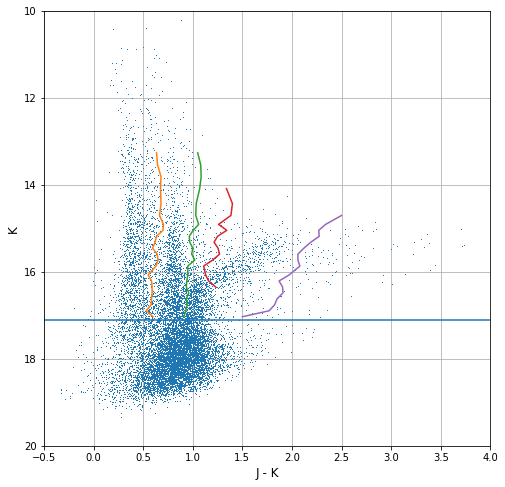

In [65]:
# 65

# K vs J-K
# CMD with color-cut points and lines
#
plt.figure(figsize=(8,8))
plt.plot(phot_data.jMINUSk, phot_data.Kmag, ',')
plt.xlim(-0.5, 4.0)
plt.ylim(20.0, 10.0)
plt.xlabel('J - K', size=12)
plt.ylabel('K', size=12)
#
### plot points
yvalues1 = [17.032, 16.895, 16.758, 16.621, 16.484, 16.347, 16.210, 16.073, 15.867, 15.730, 15.593, 15.456, 15.319, 15.182, 15.045, 14.908, 14.703, 14.429, 14.086, 13.812, 13.538, 13.264]
yvalues2 = [17.032, 16.895, 16.758, 16.621, 16.484, 16.347, 16.210, 16.073, 15.867, 15.730, 15.593, 15.456, 15.319, 15.182, 15.045, 14.908, 14.703, 14.429, 14.086, 13.812, 13.538, 13.264]
yvalues3 = [16.347, 16.210, 16.073, 15.867, 15.730, 15.593, 15.456, 15.319, 15.182, 15.045, 14.908, 14.703, 14.429, 14.086]#, 13.812, 13.538]
yvalues4 = [17.032, 16.895, 16.758, 16.621, 16.484, 16.347, 16.210, 16.073, 15.867, 15.730, 15.593, 15.456, 15.319, 15.182, 15.045, 14.908, 14.703]
boundary1 = [0.600, 0.530, 0.580, 0.585, 0.590, 0.590, 0.585, 0.550, 0.630, 0.650, 0.642, 0.595, 0.620, 0.635, 0.700, 0.705, 0.665, 0.680, 0.675, 0.680, 0.645, 0.635]
boundary2 = [0.910, 0.930, 0.945, 0.935, 0.960, 0.935, 0.940, 0.950, 0.950, 1.020, 0.990, 1.000, 0.970, 0.965, 1.005, 1.060, 1.030, 1.035, 1.070, 1.085, 1.080, 1.050]
boundary3 = [1.230, 1.160, 1.130, 1.110, 1.200, 1.270, 1.255, 1.215, 1.250, 1.343, 1.260, 1.385, 1.400, 1.340]#, 1.250, 1.220]
boundary4 = [1.500, 1.770, 1.825, 1.850, 1.910, 1.905, 1.870, 1.970, 2.080, 2.060, 2.060, 2.120, 2.190, 2.275, 2.270, 2.340, 2.500]
#
plt.plot(boundary1, yvalues1)
plt.plot(boundary2, yvalues2)
plt.plot(boundary3, yvalues3)
plt.plot(boundary4, yvalues4)
plt.axhline(y=17.1)
#plt.axvline(x=0.74)
#
plt.grid(True)
plt.show()
plt.close()